# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [KMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
    * Provide a grid plot of the first 10/12 examples with associated labels
    * Split using the provided pytorch objects into train/validation/test sets
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion. Discuss the choice you made in the report.
3. Summarise your results in a table and comment on them in the report. 
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.
    * Beyond accuracy provide the confusion matrix for the model outputs. Discuss differences between train/validation/test sets. Is accuracy a good metric in this case why or why not?

# Data Integration and Exploration

In [1]:
import torch
import torch.nn as nn # basic building blocks for graphs
import torch.nn.functional as F # dropout, loss, activation functions, and more
import torchvision # popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms # common image transformations

import matplotlib.pyplot as plt
import numpy as np
from time import time

from tqdm import tqdm


In [3]:
BS = 128 # Define batch size
data_transforms = transforms.ToTensor()

In [4]:
data = torchvision.datasets.KMNIST(
    root='./data', train=True, download=True, transform=data_transforms
)
# I won't define the train_loader as I will do the hold-out split later for model validation

test = torchvision.datasets.KMNIST(
    root='./data', train=False, download=True, transform=data_transforms
)
test_loader = torch.utils.data.DataLoader(test)


In [5]:
# Avoids jupyter kernel crashes
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

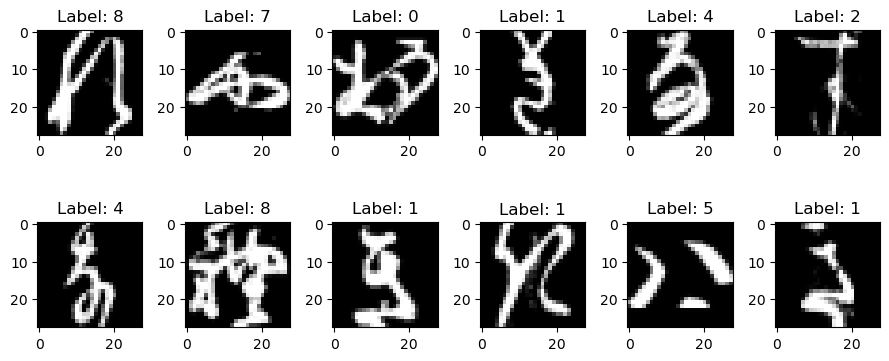

In [6]:
# Visualize first 12 samples of data
num_row = 2
num_col = 6

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(data.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(data.targets[i]))
plt.tight_layout()
plt.show()

In [7]:
data.data[0].shape 
# Each image is 28x28 with 1 channel only (greyscale), so a batch is BS X 28 X 28

torch.Size([28, 28])

In [8]:
# Use hold-out method on train dataset for train-validation splitting. Proportion is 70-30
from torch.utils.data.sampler import SubsetRandomSampler

N = len(data)
idx = list(range(N))

train_size = int(np.floor(N * 0.7))

shuffle_dataset = True
if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(idx)

train_idx, val_idx = idx[:train_size], idx[train_size:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size = BS, sampler=train_idx)
val_loader = torch.utils.data.DataLoader(data, batch_size = BS, sampler=val_idx)


# Modelling

> **NOTE.** FFNNs (Feed Forward Neural Networks) is written as "FCNN" as an accidental typo. So in this notebook by "FCNN" we actually mean "FFNN".

## CNNs

In [84]:
class DeepCNN(nn.Module):
    """
    A 'deep' version of CNN. It contains 3 convolutional layers (3 hidden) and a final linear layer (output). 
    Moreover it contains two layers of maxpooling.
    """
    def __init__(self, regularize=False, regularize_params = {"conv_p": 0.2, "conv_blocksize": 3, 'lin_p': 0.5}):
        super().__init__()

        # Convolution Layer 1: BS x 28 x 28 -> BS X 28 x 28 x 16
        self.conv_layer_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Pooling: BS X 28 x 28 x 16 -> BS x 14 x 14 x 16
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Hidden Layer 1: BS x 14 x 14 x 16 -> BS x 10 x 10 x 32
        self.hidden_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)

        # maxpooling again: BS x 10 x 10 x 32 -> BS x 5 x 5 x 32
        self.pool_2 = nn.MaxPool2d(kernel_size=2)

        # Final Linear Layer: BS x 800 -> 10
        self.final = nn.Linear(800, 10)

        self.regularize = regularize # boolean value
        if self.regularize:
            self.dropout_conv = torchvision.ops.DropBlock2d(p = regularize_params['conv_p'], block_size=regularize_params['conv_blocksize'])
            self.dropout_linear = torch.nn.Dropout(p=regularize_params['lin_p'])


    def forward(self, x):
        x = self.conv_layer_1(x)
        x = F.relu(x)
        x = self.pool_1(x)

        if self.regularize:
            x = self.dropout_conv(x)

        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.pool_2(x)

        x = x.flatten(start_dim=1)

        if self.regularize:
            x = self.dropout_linear(x)

        x = self.final(x)

        return x 

In [34]:
class ShallowCNN(nn.Module):
    """
    A 'shallow' version of CNN. It contains only a convolutional layer, a pooling layer and an output layer.
    Moreover it contains one layer of pooling, which can be parametrized as:
        - max: max pooling
        - min: min pooling
        - avg: average pooling
        - adaptive_avg: adaptive average pooling, parametrised average pooling
    We can also parametrize the number of channels.

    This is used as a baseline CNN, to deduct the "good" amount of channels to use, and which pooling type to use.
    """
    def __init__(self, regularize=False, regularize_params = {"conv_p": 0.2, "conv_blocksize": 3, 'lin_p': 0.5}, pooling_type = 'max', num_channels=3):
        super().__init__()

        # Convolution Layer 1: BS x 28 x 28 -> BS X 24 x 24 x n
        self.conv_layer_1 = nn.Conv2d(in_channels=1, out_channels=num_channels, kernel_size=5)

        self.minpool_flag = False
        # Pooling: BS X 24 x 24 x n -> BS x 12 x 12 x n
        if pooling_type == 'max' or pooling_type == 'min':
            self.pool_1 = nn.MaxPool2d(kernel_size=2)
            if pooling_type == 'min':
                self.minpool_flag = True

        elif pooling_type == 'avg':
            self.pool_1 = nn.AvgPool2d(kernel_size=2)
        elif pooling_type == 'adaptive_avg':
            self.pool_1 = nn.AdaptiveAvgPool2d(output_size=12)

        # Final Linear Layer: BS x 216 -> 10
        self.final = nn.Linear(12*12*num_channels, 10)

        self.regularize = regularize # boolean value
        if self.regularize:
            self.dropout_conv = torchvision.ops.DropBlock2d(p = regularize_params['conv_p'], block_size=regularize_params['conv_blocksize'])
            self.dropout_linear = torch.nn.Dropout(p=regularize_params['lin_p'])



    def forward(self, x):
        x = self.conv_layer_1(x)
        x = F.relu(x)

        if not self.minpool_flag:
            x = self.pool_1(x)
        else:
            x = -1 * self.pool_1(-x)

        if self.regularize:
            x = self.dropout_conv(x)

        x = x.flatten(start_dim=1)

        if self.regularize:
            x = self.dropout_linear(x)

        x = self.final(x)

        return x 

## FCNNs

In [22]:
class FCNN(nn.Module):
    def __init__(self, regularize=False, regularize_param = 0.2):
        super().__init__()

        self.layer_1 = nn.Linear(28*28, 1024)
        self.layer_2 = nn.Linear(1024, 2048)
        self.layer_3 = nn.Linear(2048, 512)
        self.out = nn.Linear(512, 10)

        self.regularize = regularize # boolean value
        if self.regularize:
            self.dropout = torch.nn.Dropout(p=regularize_param)


    def forward(self, x):
        x = x.flatten(start_dim=1)
        
        if self.regularize:
            x = self.dropout(x)

        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.tanh(x)
        x = self.layer_3(x)
        x = F.relu(x)
        x = self.out(x)

        return x

In [23]:
class ShallowFCNN(nn.Module):
    """Baseline model. Has only one hidden layers with 512 neurons"""
    def __init__(self, regularize=False, regularize_param = 0.2):
        super().__init__()

        self.layer_1 = nn.Linear(28*28, 512)
        self.out = nn.Linear(512, 10)

        self.regularize = regularize # boolean value
        if self.regularize:
            self.dropout = torch.nn.Dropout(p=regularize_param)


    def forward(self, x):
        x = x.flatten(start_dim=1)
        
        if self.regularize:
            x = self.dropout(x)

        x = self.layer_1(x)
        x = F.relu(x)
        x = self.out(x)

        return x

## Define Auxiliary Functions (define the training logic, testing logic, and get confusion matrix)

In [24]:
# functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, testloader, criterion, optimizer, scheduler):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    train_losses = []
    test_losses = []
    print("TRAINING MODEL!")

    last_lr = 0
    for epoch in (range(num_epochs)):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model.train()
        start = time()
        ## training step
        for i_1, (images, labels) in tqdm(enumerate(trainloader)):
            
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
            
        train_losses.append(train_running_loss / i_1)
        ## testing step
        
        model.eval()
        test_running_loss = 0.0
        test_acc = 0.0
        for i_2, (images, labels) in tqdm(enumerate(testloader)):
            images = images.to(device)
            labels = labels.to(device)

            ## fp -> loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            ## update model params

            test_running_loss += loss.item()
            test_acc += get_accuracy(logits, labels)

        test_losses.append(test_running_loss/i_2)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_running_loss / i_2)
        if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
            scheduler.step(epoch + i_1 / len(trainloader))
        else:
            scheduler.step()

        if scheduler.get_last_lr()[0] != last_lr:
            last_lr = scheduler.get_last_lr()[0]
            print("Learning rate set to", last_lr)


        print(f"Epoch: {epoch+1} | Train Loss: {train_running_loss / i_1:.4f} | Test Loss: {test_running_loss / i_2:.4f} | Train Accuracy: {train_acc/i_1:.4f} | Test Accuracy: {test_acc / i_2:.4f} | Time: {time()-start:.2f}") 
    
    return train_losses, test_losses

In [25]:
def test_model(model, valloader, criterion):
    # get losses on test dataset

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    running_loss = 0
    print("EVALUATING MODEL LOSS!")
    model = model.eval()

    start = time()
    ## training step
    for i, (images, labels) in tqdm(enumerate(valloader)):
        
        images = images.to(device)
        labels = labels.to(device)

        ## fp -> loss
        logits = model(images)
        loss = criterion(logits, labels)

        # Reset the gradients to zero
        ## update model params

        running_loss += loss.item()
        
            

    print(f"Average Loss: {running_loss/i} | Time: {time()-start:.2f}") 
    
    return running_loss/i

In [26]:
import sklearn.metrics 

def val_model(model, valloader, data):
    # Obs. data parameter is just to get the number of classes

    model.eval() # Sets to evaluation mode: i'm basically just freezing the gradients

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize empty confusion matrix
    CLASSES = data.targets.unique()

    CLASSES = CLASSES.to(device)
    
    N_CLASSES = CLASSES.shape[0]

    my_confusion_matrix = torch.zeros((N_CLASSES, N_CLASSES))

    print("EVALUATING MODEL")
    for images, labels in tqdm(valloader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_hat = model(images)
        y_pred = torch.argmax(y_hat, dim=1)

        # Copy to CPU memory since i'm going to use sklearn (idk)
        labels_ = labels.cpu()
        y_pred_ = y_pred.cpu()
        CLASSES_= CLASSES.cpu()

        cm_i = sklearn.metrics.confusion_matrix(labels_, y_pred_, labels=CLASSES_)

        my_confusion_matrix += cm_i
    
    return my_confusion_matrix

In [27]:
def save_model(model, train_loss, test_loss, model_name):
    """Saves neural network's weights and his loss during training phase.
    
    Used for preservation purposes, incase I need to reuse models/losses for some reason."""

    fname_weights = f"./weights/{model_name}"
    fname_train_loss = f"./losses/{model_name}_train_loss.csv"
    fname_test_loss = f"./losses/{model_name}_test_loss.csv"

    try:
        torch.save(model.state_dict(), fname_weights)
        np.savetxt(fname_train_loss, train_loss, delimiter=',', fmt='%.16f')
        np.savetxt(fname_test_loss, test_loss, delimiter=',', fmt='%.16f')
    except Exception as e:
        return (-1, e)
    else:
        return 1


In [28]:
# define cross entropy loss
CE = nn.CrossEntropyLoss()

# Training

In [29]:
models = {} # Every entry of this dictionary contains the model, the optimizer, the scheduler and the train and test loss. Done for easy accessibility

## Baseline Model: Shallow FCNN

In [30]:
name = 'sgd_shallow_fcnn'

models[name] = {}
entry = models[name] 

entry['model'] = ShallowFCNN()

# Initialize all weights to zero for preservability purposes
for m in entry['model'].modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.zeros_(m.weight.data)

entry['optimizer'] = torch.optim.SGD(entry['model'].parameters(), lr = 0.1)
entry['scheduler'] = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(entry['optimizer'], T_0=10)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:03, 86.06it/s]
141it [00:01, 95.36it/s]


Learning rate set to 0.09756755801603949
Epoch: 1 | Train Loss: 2.0933 | Test Loss: 1.9356 | Train Accuracy: 16.4158 | Test Accuracy: 18.3069 | Time: 5.31


329it [00:03, 83.13it/s]
141it [00:01, 92.40it/s]


Learning rate set to 0.09047889482624139
Epoch: 2 | Train Loss: 1.7929 | Test Loss: 1.4029 | Train Accuracy: 30.3258 | Test Accuracy: 55.2857 | Time: 5.49


329it [00:04, 80.29it/s]
141it [00:01, 95.37it/s]


Learning rate set to 0.07942787537780661
Epoch: 3 | Train Loss: 0.9740 | Test Loss: 0.7396 | Train Accuracy: 70.4721 | Test Accuracy: 77.7679 | Time: 5.58


329it [00:03, 84.96it/s]
141it [00:01, 93.13it/s]


Learning rate set to 0.065496250451328
Epoch: 4 | Train Loss: 0.5849 | Test Loss: 0.5948 | Train Accuracy: 82.6339 | Test Accuracy: 82.3013 | Time: 5.39


329it [00:03, 83.10it/s]
141it [00:01, 98.06it/s] 


Learning rate set to 0.05004774456194777
Epoch: 5 | Train Loss: 0.4894 | Test Loss: 0.5185 | Train Accuracy: 85.5159 | Test Accuracy: 84.8493 | Time: 5.40


329it [00:03, 85.02it/s]
141it [00:01, 95.43it/s]


Learning rate set to 0.0345945651021882
Epoch: 6 | Train Loss: 0.4427 | Test Loss: 0.4701 | Train Accuracy: 87.1189 | Test Accuracy: 86.6060 | Time: 5.36


329it [00:03, 83.76it/s]
141it [00:01, 94.27it/s]


Learning rate set to 0.02064937694620286
Epoch: 7 | Train Loss: 0.4140 | Test Loss: 0.4432 | Train Accuracy: 87.9502 | Test Accuracy: 87.4096 | Time: 5.43


329it [00:03, 82.67it/s]
141it [00:01, 94.63it/s]


Learning rate set to 0.009577232272538745
Epoch: 8 | Train Loss: 0.3965 | Test Loss: 0.4293 | Train Accuracy: 88.4480 | Test Accuracy: 87.9710 | Time: 5.48


329it [00:03, 84.71it/s]
141it [00:01, 95.85it/s] 


Learning rate set to 0.0024619497460222186
Epoch: 9 | Train Loss: 0.3869 | Test Loss: 0.4227 | Train Accuracy: 88.7671 | Test Accuracy: 88.0714 | Time: 5.36


329it [00:04, 80.95it/s]
141it [00:01, 85.02it/s]


Learning rate set to 2.2795437154554678e-08
Epoch: 10 | Train Loss: 0.3828 | Test Loss: 0.4203 | Train Accuracy: 88.9529 | Test Accuracy: 88.1908 | Time: 5.73


329it [00:05, 63.41it/s]
141it [00:01, 76.19it/s]


Learning rate set to 0.09756755801603949
Epoch: 11 | Train Loss: 0.3815 | Test Loss: 0.4203 | Train Accuracy: 88.9768 | Test Accuracy: 88.1908 | Time: 7.05


329it [00:08, 40.57it/s]
141it [00:02, 47.04it/s]


Learning rate set to 0.09047889482624139
Epoch: 12 | Train Loss: 0.3790 | Test Loss: 0.4455 | Train Accuracy: 88.8982 | Test Accuracy: 86.9743 | Time: 11.11


329it [00:05, 57.75it/s]
141it [00:02, 54.10it/s]


Learning rate set to 0.0794278753778066
Epoch: 13 | Train Loss: 0.3434 | Test Loss: 0.3983 | Train Accuracy: 89.9628 | Test Accuracy: 88.6094 | Time: 8.31


329it [00:06, 53.01it/s]
141it [00:02, 62.93it/s]


Learning rate set to 0.06549625045132797
Epoch: 14 | Train Loss: 0.3155 | Test Loss: 0.3651 | Train Accuracy: 90.8679 | Test Accuracy: 89.6562 | Time: 8.46


329it [00:05, 55.39it/s]
141it [00:02, 55.22it/s]


Learning rate set to 0.050047744561947764
Epoch: 15 | Train Loss: 0.2937 | Test Loss: 0.3430 | Train Accuracy: 91.5301 | Test Accuracy: 90.4911 | Time: 8.50


329it [00:05, 58.72it/s]
141it [00:02, 59.22it/s]


Learning rate set to 0.03459456510218818
Epoch: 16 | Train Loss: 0.2773 | Test Loss: 0.3290 | Train Accuracy: 92.0613 | Test Accuracy: 90.9319 | Time: 7.99


329it [00:05, 58.35it/s]
141it [00:01, 83.17it/s]


Learning rate set to 0.020649376946202877
Epoch: 17 | Train Loss: 0.2653 | Test Loss: 0.3206 | Train Accuracy: 92.5114 | Test Accuracy: 91.2109 | Time: 7.35


329it [00:03, 87.03it/s]
141it [00:01, 93.86it/s]


Learning rate set to 0.009577232272538755
Epoch: 18 | Train Loss: 0.2571 | Test Loss: 0.3158 | Train Accuracy: 92.8592 | Test Accuracy: 91.3839 | Time: 5.29


329it [00:03, 84.33it/s]
141it [00:01, 97.18it/s]


Learning rate set to 0.002461949746022224
Epoch: 19 | Train Loss: 0.2521 | Test Loss: 0.3130 | Train Accuracy: 93.0140 | Test Accuracy: 91.4286 | Time: 5.36


329it [00:03, 88.47it/s]
141it [00:01, 100.68it/s]


Learning rate set to 2.2795437154554678e-08
Epoch: 20 | Train Loss: 0.2497 | Test Loss: 0.3120 | Train Accuracy: 93.0878 | Test Accuracy: 91.3951 | Time: 5.13


329it [00:04, 80.12it/s]
141it [00:01, 75.30it/s]


Learning rate set to 0.0975675580160395
Epoch: 21 | Train Loss: 0.2489 | Test Loss: 0.3120 | Train Accuracy: 93.0998 | Test Accuracy: 91.3951 | Time: 5.99


329it [00:04, 78.36it/s]
141it [00:01, 98.02it/s] 


Learning rate set to 0.0904788948262414
Epoch: 22 | Train Loss: 0.2566 | Test Loss: 0.3214 | Train Accuracy: 92.7615 | Test Accuracy: 91.0312 | Time: 5.64


329it [00:03, 85.39it/s]
141it [00:01, 95.46it/s]


Learning rate set to 0.07942787537780663
Epoch: 23 | Train Loss: 0.2390 | Test Loss: 0.3041 | Train Accuracy: 93.4070 | Test Accuracy: 91.7154 | Time: 5.34


329it [00:03, 85.88it/s]
141it [00:01, 93.67it/s]


Learning rate set to 0.06549625045132801
Epoch: 24 | Train Loss: 0.2233 | Test Loss: 0.2908 | Train Accuracy: 93.9167 | Test Accuracy: 92.1395 | Time: 5.34


329it [00:03, 85.18it/s]
141it [00:01, 92.24it/s]


Learning rate set to 0.0500477445619478
Epoch: 25 | Train Loss: 0.2102 | Test Loss: 0.2807 | Train Accuracy: 94.4074 | Test Accuracy: 92.4185 | Time: 5.40


329it [00:04, 79.12it/s]
141it [00:01, 84.56it/s]


Learning rate set to 0.03459456510218822
Epoch: 26 | Train Loss: 0.1996 | Test Loss: 0.2735 | Train Accuracy: 94.7313 | Test Accuracy: 92.5469 | Time: 5.83


329it [00:03, 83.72it/s]
141it [00:01, 96.05it/s]


Learning rate set to 0.020649376946202877
Epoch: 27 | Train Loss: 0.1915 | Test Loss: 0.2688 | Train Accuracy: 95.0148 | Test Accuracy: 92.7254 | Time: 5.40


329it [00:04, 75.49it/s]
141it [00:01, 97.10it/s]


Learning rate set to 0.009577232272538755
Epoch: 28 | Train Loss: 0.1857 | Test Loss: 0.2658 | Train Accuracy: 95.2125 | Test Accuracy: 92.7812 | Time: 5.82


329it [00:03, 84.36it/s]
141it [00:01, 96.56it/s] 


Learning rate set to 0.002461949746022224
Epoch: 29 | Train Loss: 0.1821 | Test Loss: 0.2640 | Train Accuracy: 95.3268 | Test Accuracy: 92.8147 | Time: 5.37


329it [00:03, 82.70it/s]
141it [00:01, 97.97it/s] 


Learning rate set to 2.2795437154554678e-08
Epoch: 30 | Train Loss: 0.1802 | Test Loss: 0.2633 | Train Accuracy: 95.3720 | Test Accuracy: 92.8705 | Time: 5.42


329it [00:04, 77.41it/s]
141it [00:01, 84.69it/s]


Learning rate set to 0.0975675580160395
Epoch: 31 | Train Loss: 0.1795 | Test Loss: 0.2633 | Train Accuracy: 95.4125 | Test Accuracy: 92.8705 | Time: 5.92


329it [00:04, 78.26it/s]
141it [00:01, 87.34it/s]


Learning rate set to 0.0904788948262414
Epoch: 32 | Train Loss: 0.1889 | Test Loss: 0.2717 | Train Accuracy: 94.9862 | Test Accuracy: 92.5469 | Time: 5.83


329it [00:03, 83.48it/s]
141it [00:01, 95.14it/s]


Learning rate set to 0.07942787537780663
Epoch: 33 | Train Loss: 0.1772 | Test Loss: 0.2631 | Train Accuracy: 95.3649 | Test Accuracy: 92.8761 | Time: 5.43


329it [00:04, 77.99it/s]
141it [00:01, 100.67it/s]


Learning rate set to 0.06549625045132801
Epoch: 34 | Train Loss: 0.1663 | Test Loss: 0.2557 | Train Accuracy: 95.7150 | Test Accuracy: 93.0993 | Time: 5.63


329it [00:04, 78.79it/s]
141it [00:01, 89.84it/s]


Learning rate set to 0.0500477445619478
Epoch: 35 | Train Loss: 0.1569 | Test Loss: 0.2498 | Train Accuracy: 96.0175 | Test Accuracy: 93.2612 | Time: 5.75


329it [00:03, 88.69it/s] 
141it [00:01, 110.27it/s]


Learning rate set to 0.03459456510218822
Epoch: 36 | Train Loss: 0.1492 | Test Loss: 0.2451 | Train Accuracy: 96.2533 | Test Accuracy: 93.4397 | Time: 5.00


329it [00:03, 93.21it/s] 
141it [00:01, 104.72it/s]


Learning rate set to 0.020649376946202877
Epoch: 37 | Train Loss: 0.1432 | Test Loss: 0.2417 | Train Accuracy: 96.4606 | Test Accuracy: 93.5513 | Time: 4.88


329it [00:03, 88.56it/s]
141it [00:01, 93.04it/s]


Learning rate set to 0.009577232272538755
Epoch: 38 | Train Loss: 0.1389 | Test Loss: 0.2393 | Train Accuracy: 96.6058 | Test Accuracy: 93.6295 | Time: 5.24


329it [00:04, 75.34it/s]
141it [00:01, 76.30it/s]


Learning rate set to 0.002461949746022224
Epoch: 39 | Train Loss: 0.1361 | Test Loss: 0.2378 | Train Accuracy: 96.7297 | Test Accuracy: 93.6295 | Time: 6.22


329it [00:03, 83.23it/s]
141it [00:01, 91.02it/s]


Learning rate set to 2.2795437154554678e-08
Epoch: 40 | Train Loss: 0.1346 | Test Loss: 0.2372 | Train Accuracy: 96.7988 | Test Accuracy: 93.6574 | Time: 5.51


329it [00:03, 83.92it/s]
141it [00:01, 97.97it/s] 


Learning rate set to 0.0975675580160395
Epoch: 41 | Train Loss: 0.1341 | Test Loss: 0.2372 | Train Accuracy: 96.8512 | Test Accuracy: 93.6574 | Time: 5.36


329it [00:03, 88.45it/s]
141it [00:01, 80.73it/s]


Learning rate set to 0.0904788948262414
Epoch: 42 | Train Loss: 0.1434 | Test Loss: 0.2480 | Train Accuracy: 96.3772 | Test Accuracy: 93.2723 | Time: 5.47


329it [00:04, 72.36it/s]
141it [00:01, 81.73it/s]


Learning rate set to 0.07942787537780663
Epoch: 43 | Train Loss: 0.1351 | Test Loss: 0.2426 | Train Accuracy: 96.7011 | Test Accuracy: 93.4676 | Time: 6.28


329it [00:04, 78.41it/s]
141it [00:02, 55.20it/s]


Learning rate set to 0.06549625045132801
Epoch: 44 | Train Loss: 0.1272 | Test Loss: 0.2377 | Train Accuracy: 96.9417 | Test Accuracy: 93.5402 | Time: 6.76


329it [00:05, 60.42it/s]
141it [00:01, 73.16it/s]


Learning rate set to 0.0500477445619478
Epoch: 45 | Train Loss: 0.1202 | Test Loss: 0.2334 | Train Accuracy: 97.2251 | Test Accuracy: 93.6629 | Time: 7.38


329it [00:04, 70.65it/s]
141it [00:01, 94.18it/s]


Learning rate set to 0.03459456510218822
Epoch: 46 | Train Loss: 0.1144 | Test Loss: 0.2300 | Train Accuracy: 97.4157 | Test Accuracy: 93.7857 | Time: 6.17


329it [00:04, 81.32it/s]
141it [00:01, 83.81it/s]


Learning rate set to 0.020649376946202877
Epoch: 47 | Train Loss: 0.1099 | Test Loss: 0.2272 | Train Accuracy: 97.5896 | Test Accuracy: 93.8080 | Time: 5.74


329it [00:05, 63.51it/s]
141it [00:01, 87.26it/s]


Learning rate set to 0.009577232272538755
Epoch: 48 | Train Loss: 0.1066 | Test Loss: 0.2253 | Train Accuracy: 97.7015 | Test Accuracy: 93.8638 | Time: 6.81


329it [00:06, 50.62it/s]
141it [00:02, 65.04it/s]


Learning rate set to 0.002461949746022224
Epoch: 49 | Train Loss: 0.1044 | Test Loss: 0.2239 | Train Accuracy: 97.7563 | Test Accuracy: 93.9810 | Time: 8.68


329it [00:04, 72.19it/s]
141it [00:01, 77.55it/s]


Learning rate set to 2.2795437154554678e-08
Epoch: 50 | Train Loss: 0.1032 | Test Loss: 0.2234 | Train Accuracy: 97.7992 | Test Accuracy: 94.0257 | Time: 6.38


In [31]:
name = 'adam_shallow_fcnn'

models[name] = {}
entry = models[name] 

entry['model'] = ShallowFCNN()

# Initialize all weights to zero for preservability purposes
for m in entry['model'].modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.zeros_(m.weight.data)

entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=10, gamma=0.5)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:04, 66.50it/s]
141it [00:01, 76.57it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.8470 | Test Loss: 0.3954 | Train Accuracy: 71.8941 | Test Accuracy: 88.8850 | Time: 6.80


329it [00:06, 52.74it/s]
141it [00:01, 83.37it/s]


Epoch: 2 | Train Loss: 0.3237 | Test Loss: 0.3400 | Train Accuracy: 90.6202 | Test Accuracy: 90.7277 | Time: 7.94


329it [00:06, 50.86it/s]
141it [00:02, 57.59it/s]


Epoch: 3 | Train Loss: 0.2548 | Test Loss: 0.3342 | Train Accuracy: 92.5376 | Test Accuracy: 91.4922 | Time: 8.93


329it [00:05, 63.73it/s]
141it [00:03, 40.20it/s]


Epoch: 4 | Train Loss: 0.2175 | Test Loss: 0.3381 | Train Accuracy: 93.7429 | Test Accuracy: 91.9185 | Time: 8.68


329it [00:09, 35.51it/s]
141it [00:01, 74.98it/s]


Epoch: 5 | Train Loss: 0.1856 | Test Loss: 0.3393 | Train Accuracy: 94.6456 | Test Accuracy: 92.3259 | Time: 11.15


329it [00:05, 59.03it/s]
141it [00:01, 74.14it/s]


Epoch: 6 | Train Loss: 0.1742 | Test Loss: 0.3413 | Train Accuracy: 94.8766 | Test Accuracy: 92.3571 | Time: 7.48


329it [00:06, 51.16it/s]
141it [00:01, 83.45it/s]


Epoch: 7 | Train Loss: 0.1539 | Test Loss: 0.3869 | Train Accuracy: 95.5102 | Test Accuracy: 91.8025 | Time: 8.13


329it [00:05, 60.70it/s]
141it [00:02, 51.98it/s]


Epoch: 8 | Train Loss: 0.1417 | Test Loss: 0.4211 | Train Accuracy: 95.8794 | Test Accuracy: 91.8158 | Time: 8.14


329it [00:04, 71.97it/s]
141it [00:02, 66.83it/s]


Epoch: 9 | Train Loss: 0.1350 | Test Loss: 0.4145 | Train Accuracy: 96.2033 | Test Accuracy: 92.1451 | Time: 6.69


329it [00:04, 66.96it/s]
141it [00:02, 52.18it/s]


Learning rate set to 0.005
Epoch: 10 | Train Loss: 0.1276 | Test Loss: 0.4412 | Train Accuracy: 96.3724 | Test Accuracy: 92.0279 | Time: 7.62


329it [00:05, 63.21it/s]
141it [00:01, 82.42it/s]


Epoch: 11 | Train Loss: 0.0925 | Test Loss: 0.3860 | Train Accuracy: 97.4181 | Test Accuracy: 92.9241 | Time: 6.92


329it [00:04, 75.21it/s]
141it [00:01, 93.47it/s]


Epoch: 12 | Train Loss: 0.0700 | Test Loss: 0.3845 | Train Accuracy: 98.1588 | Test Accuracy: 93.1250 | Time: 5.89


329it [00:04, 80.26it/s]
141it [00:01, 94.76it/s]


Epoch: 13 | Train Loss: 0.0610 | Test Loss: 0.3988 | Train Accuracy: 98.4494 | Test Accuracy: 93.0971 | Time: 5.60


329it [00:04, 79.61it/s]
141it [00:01, 94.25it/s]


Epoch: 14 | Train Loss: 0.0537 | Test Loss: 0.4170 | Train Accuracy: 98.7471 | Test Accuracy: 93.0558 | Time: 5.64


329it [00:04, 81.09it/s]
141it [00:01, 92.73it/s]


Epoch: 15 | Train Loss: 0.0477 | Test Loss: 0.4266 | Train Accuracy: 98.9567 | Test Accuracy: 93.1897 | Time: 5.58


329it [00:04, 82.25it/s]
141it [00:01, 93.02it/s]


Epoch: 16 | Train Loss: 0.0444 | Test Loss: 0.4475 | Train Accuracy: 99.0115 | Test Accuracy: 93.0246 | Time: 5.52


329it [00:04, 79.36it/s]
141it [00:01, 89.07it/s]


Epoch: 17 | Train Loss: 0.0442 | Test Loss: 0.4969 | Train Accuracy: 98.9782 | Test Accuracy: 92.7321 | Time: 5.74


329it [00:04, 73.78it/s]
141it [00:01, 76.14it/s]


Epoch: 18 | Train Loss: 0.0492 | Test Loss: 0.4989 | Train Accuracy: 98.7757 | Test Accuracy: 92.6306 | Time: 6.32


329it [00:05, 61.55it/s]
141it [00:01, 76.08it/s]


Epoch: 19 | Train Loss: 0.0538 | Test Loss: 0.5127 | Train Accuracy: 98.6209 | Test Accuracy: 92.8516 | Time: 7.21


329it [00:05, 55.08it/s]
141it [00:01, 78.77it/s]


Learning rate set to 0.0025
Epoch: 20 | Train Loss: 0.0495 | Test Loss: 0.5564 | Train Accuracy: 98.7829 | Test Accuracy: 92.5748 | Time: 7.77


329it [00:05, 64.30it/s]
141it [00:01, 89.36it/s]


Epoch: 21 | Train Loss: 0.0341 | Test Loss: 0.5209 | Train Accuracy: 99.2878 | Test Accuracy: 92.8571 | Time: 6.70


329it [00:04, 70.10it/s]
141it [00:01, 78.18it/s]


Epoch: 22 | Train Loss: 0.0267 | Test Loss: 0.5184 | Train Accuracy: 99.6141 | Test Accuracy: 93.0502 | Time: 6.50


329it [00:04, 67.32it/s]
141it [00:01, 93.28it/s]


Epoch: 23 | Train Loss: 0.0227 | Test Loss: 0.5265 | Train Accuracy: 99.7880 | Test Accuracy: 93.1228 | Time: 6.40


329it [00:03, 83.26it/s]
141it [00:01, 87.72it/s]


Epoch: 24 | Train Loss: 0.0201 | Test Loss: 0.5339 | Train Accuracy: 99.8928 | Test Accuracy: 93.1004 | Time: 5.56


329it [00:04, 79.33it/s]
141it [00:01, 94.87it/s]


Epoch: 25 | Train Loss: 0.0183 | Test Loss: 0.5428 | Train Accuracy: 99.9190 | Test Accuracy: 93.1507 | Time: 5.64


329it [00:04, 81.74it/s]
141it [00:01, 96.22it/s] 


Epoch: 26 | Train Loss: 0.0167 | Test Loss: 0.5561 | Train Accuracy: 99.9500 | Test Accuracy: 93.0614 | Time: 5.50


329it [00:03, 82.71it/s]
141it [00:01, 95.50it/s]


Epoch: 27 | Train Loss: 0.0154 | Test Loss: 0.5666 | Train Accuracy: 100.0024 | Test Accuracy: 93.1060 | Time: 5.46


329it [00:03, 83.41it/s]
141it [00:01, 95.94it/s]


Epoch: 28 | Train Loss: 0.0150 | Test Loss: 0.5846 | Train Accuracy: 100.0000 | Test Accuracy: 93.0670 | Time: 5.42


329it [00:03, 85.22it/s]
141it [00:01, 98.25it/s] 


Epoch: 29 | Train Loss: 0.0135 | Test Loss: 0.5898 | Train Accuracy: 100.0476 | Test Accuracy: 93.0112 | Time: 5.30


329it [00:03, 83.30it/s]
141it [00:01, 96.16it/s]


Learning rate set to 0.00125
Epoch: 30 | Train Loss: 0.0131 | Test Loss: 0.6082 | Train Accuracy: 100.0333 | Test Accuracy: 93.0078 | Time: 5.42


329it [00:03, 84.91it/s]
141it [00:01, 99.05it/s]


Epoch: 31 | Train Loss: 0.0120 | Test Loss: 0.6009 | Train Accuracy: 100.0357 | Test Accuracy: 93.0781 | Time: 5.31


329it [00:04, 79.94it/s]
141it [00:01, 94.95it/s]


Epoch: 32 | Train Loss: 0.0104 | Test Loss: 0.6046 | Train Accuracy: 100.1239 | Test Accuracy: 93.1507 | Time: 5.61


329it [00:04, 80.05it/s]
141it [00:01, 86.99it/s]


Epoch: 33 | Train Loss: 0.0095 | Test Loss: 0.6122 | Train Accuracy: 100.1405 | Test Accuracy: 93.2176 | Time: 5.74


329it [00:04, 78.74it/s]
141it [00:01, 93.11it/s]


Epoch: 34 | Train Loss: 0.0087 | Test Loss: 0.6231 | Train Accuracy: 100.1572 | Test Accuracy: 93.2422 | Time: 5.70


329it [00:04, 81.23it/s]
141it [00:01, 88.67it/s]


Epoch: 35 | Train Loss: 0.0082 | Test Loss: 0.6309 | Train Accuracy: 100.1667 | Test Accuracy: 93.2344 | Time: 5.65


329it [00:04, 78.78it/s]
141it [00:01, 88.61it/s]


Epoch: 36 | Train Loss: 0.0077 | Test Loss: 0.6395 | Train Accuracy: 100.1739 | Test Accuracy: 93.2087 | Time: 5.77


329it [00:04, 81.63it/s]
141it [00:01, 91.84it/s]


Epoch: 37 | Train Loss: 0.0072 | Test Loss: 0.6497 | Train Accuracy: 100.1763 | Test Accuracy: 93.2645 | Time: 5.57


329it [00:04, 76.00it/s]
141it [00:01, 90.45it/s]


Epoch: 38 | Train Loss: 0.0068 | Test Loss: 0.6578 | Train Accuracy: 100.1810 | Test Accuracy: 93.2254 | Time: 5.89


329it [00:04, 79.84it/s]
141it [00:01, 85.54it/s]


Epoch: 39 | Train Loss: 0.0067 | Test Loss: 0.6764 | Train Accuracy: 100.1905 | Test Accuracy: 93.1362 | Time: 5.78


329it [00:04, 80.35it/s]
141it [00:01, 90.47it/s]


Learning rate set to 0.000625
Epoch: 40 | Train Loss: 0.0069 | Test Loss: 0.6762 | Train Accuracy: 100.1810 | Test Accuracy: 93.1953 | Time: 5.66


329it [00:04, 76.47it/s]
141it [00:01, 87.98it/s]


Epoch: 41 | Train Loss: 0.0060 | Test Loss: 0.6801 | Train Accuracy: 100.2048 | Test Accuracy: 93.2310 | Time: 5.91


329it [00:04, 73.89it/s]
141it [00:01, 97.59it/s]


Epoch: 42 | Train Loss: 0.0055 | Test Loss: 0.6853 | Train Accuracy: 100.2144 | Test Accuracy: 93.2254 | Time: 5.90


329it [00:04, 76.38it/s]
141it [00:01, 103.55it/s]


Epoch: 43 | Train Loss: 0.0051 | Test Loss: 0.6923 | Train Accuracy: 100.2191 | Test Accuracy: 93.2366 | Time: 5.67


329it [00:04, 74.84it/s]
141it [00:01, 85.87it/s]


Epoch: 44 | Train Loss: 0.0049 | Test Loss: 0.6973 | Train Accuracy: 100.2310 | Test Accuracy: 93.2143 | Time: 6.05


329it [00:04, 76.09it/s]
141it [00:01, 90.55it/s]


Epoch: 45 | Train Loss: 0.0046 | Test Loss: 0.7048 | Train Accuracy: 100.2310 | Test Accuracy: 93.1920 | Time: 5.89


329it [00:04, 72.73it/s]
141it [00:01, 85.30it/s]


Epoch: 46 | Train Loss: 0.0044 | Test Loss: 0.7118 | Train Accuracy: 100.2334 | Test Accuracy: 93.2310 | Time: 6.19


329it [00:04, 71.56it/s]
141it [00:01, 87.99it/s]


Epoch: 47 | Train Loss: 0.0042 | Test Loss: 0.7172 | Train Accuracy: 100.2334 | Test Accuracy: 93.2310 | Time: 6.21


329it [00:04, 71.51it/s]
141it [00:01, 88.93it/s]


Epoch: 48 | Train Loss: 0.0041 | Test Loss: 0.7258 | Train Accuracy: 100.2334 | Test Accuracy: 93.1473 | Time: 6.19


329it [00:04, 72.66it/s]
141it [00:01, 90.57it/s]


Epoch: 49 | Train Loss: 0.0040 | Test Loss: 0.7337 | Train Accuracy: 100.2382 | Test Accuracy: 93.1975 | Time: 6.09


329it [00:04, 70.42it/s]
141it [00:01, 81.87it/s]


Learning rate set to 0.0003125
Epoch: 50 | Train Loss: 0.0038 | Test Loss: 0.7368 | Train Accuracy: 100.2453 | Test Accuracy: 93.1696 | Time: 6.40


## Shallow FCNN: Random initialization

In [32]:
name = 'sgd_shallow_fcnn_random_initialization' # let pytorch initialize, just to see what happens

models[name] = {}
entry = models[name] 

entry['model'] = ShallowFCNN()
entry['optimizer'] = torch.optim.SGD(entry['model'].parameters(), lr = 0.1)
entry['scheduler'] = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(entry['optimizer'], T_0=10)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:03, 83.32it/s]
141it [00:01, 97.74it/s] 


Learning rate set to 0.09756755801603949
Epoch: 1 | Train Loss: 0.8834 | Test Loss: 0.7425 | Train Accuracy: 75.7670 | Test Accuracy: 76.4342 | Time: 5.40


329it [00:03, 85.22it/s]
141it [00:01, 96.29it/s]


Learning rate set to 0.09047889482624139
Epoch: 2 | Train Loss: 0.4874 | Test Loss: 0.5093 | Train Accuracy: 86.0209 | Test Accuracy: 85.0112 | Time: 5.33


329it [00:03, 84.07it/s]
141it [00:01, 93.69it/s]


Learning rate set to 0.07942787537780661
Epoch: 3 | Train Loss: 0.3881 | Test Loss: 0.4127 | Train Accuracy: 88.8934 | Test Accuracy: 88.2277 | Time: 5.43


329it [00:03, 86.76it/s]
141it [00:01, 96.73it/s]


Learning rate set to 0.065496250451328
Epoch: 4 | Train Loss: 0.3293 | Test Loss: 0.3570 | Train Accuracy: 90.7393 | Test Accuracy: 90.3092 | Time: 5.26


329it [00:03, 83.80it/s]
141it [00:01, 97.31it/s] 


Learning rate set to 0.05004774456194777
Epoch: 5 | Train Loss: 0.2910 | Test Loss: 0.3221 | Train Accuracy: 91.9803 | Test Accuracy: 91.3170 | Time: 5.38


329it [00:04, 82.18it/s]
141it [00:01, 92.45it/s]


Learning rate set to 0.0345945651021882
Epoch: 6 | Train Loss: 0.2651 | Test Loss: 0.3013 | Train Accuracy: 92.7591 | Test Accuracy: 92.0424 | Time: 5.53


329it [00:03, 83.02it/s]
141it [00:01, 96.39it/s]


Learning rate set to 0.02064937694620286
Epoch: 7 | Train Loss: 0.2477 | Test Loss: 0.2893 | Train Accuracy: 93.3784 | Test Accuracy: 92.3940 | Time: 5.43


329it [00:04, 78.40it/s]
141it [00:01, 93.25it/s]


Learning rate set to 0.009577232272538745
Epoch: 8 | Train Loss: 0.2367 | Test Loss: 0.2828 | Train Accuracy: 93.6762 | Test Accuracy: 92.6004 | Time: 5.72


329it [00:03, 86.93it/s]
141it [00:01, 91.19it/s]


Learning rate set to 0.0024619497460222186
Epoch: 9 | Train Loss: 0.2303 | Test Loss: 0.2796 | Train Accuracy: 93.9001 | Test Accuracy: 92.6953 | Time: 5.34


329it [00:03, 83.26it/s]
141it [00:01, 92.32it/s]


Learning rate set to 2.2795437154554678e-08
Epoch: 10 | Train Loss: 0.2275 | Test Loss: 0.2786 | Train Accuracy: 94.0263 | Test Accuracy: 92.6786 | Time: 5.49


329it [00:03, 82.59it/s]
141it [00:01, 96.03it/s] 


Learning rate set to 0.09756755801603949
Epoch: 11 | Train Loss: 0.2266 | Test Loss: 0.2786 | Train Accuracy: 94.0263 | Test Accuracy: 92.6786 | Time: 5.46


329it [00:03, 84.45it/s]
141it [00:01, 96.96it/s]


Learning rate set to 0.09047889482624139
Epoch: 12 | Train Loss: 0.2276 | Test Loss: 0.2723 | Train Accuracy: 93.9596 | Test Accuracy: 92.7009 | Time: 5.36


329it [00:03, 85.93it/s]
141it [00:01, 89.61it/s]


Learning rate set to 0.0794278753778066
Epoch: 13 | Train Loss: 0.2034 | Test Loss: 0.2521 | Train Accuracy: 94.6527 | Test Accuracy: 93.3259 | Time: 5.41


329it [00:04, 81.69it/s]
141it [00:01, 96.42it/s]


Learning rate set to 0.06549625045132797
Epoch: 14 | Train Loss: 0.1838 | Test Loss: 0.2380 | Train Accuracy: 95.3411 | Test Accuracy: 93.7165 | Time: 5.50


329it [00:04, 80.74it/s]
141it [00:01, 97.90it/s]


Learning rate set to 0.050047744561947764
Epoch: 15 | Train Loss: 0.1685 | Test Loss: 0.2280 | Train Accuracy: 95.8413 | Test Accuracy: 94.0402 | Time: 5.52


329it [00:03, 83.10it/s]
141it [00:01, 100.44it/s]


Learning rate set to 0.03459456510218818
Epoch: 16 | Train Loss: 0.1570 | Test Loss: 0.2211 | Train Accuracy: 96.2367 | Test Accuracy: 94.2355 | Time: 5.37


329it [00:03, 83.84it/s]
141it [00:01, 97.02it/s]


Learning rate set to 0.020649376946202877
Epoch: 17 | Train Loss: 0.1486 | Test Loss: 0.2168 | Train Accuracy: 96.4987 | Test Accuracy: 94.3471 | Time: 5.38


329it [00:03, 84.37it/s]
141it [00:01, 96.51it/s]


Learning rate set to 0.009577232272538755
Epoch: 18 | Train Loss: 0.1429 | Test Loss: 0.2144 | Train Accuracy: 96.6940 | Test Accuracy: 94.4364 | Time: 5.37


329it [00:03, 89.47it/s]
141it [00:01, 98.76it/s] 


Learning rate set to 0.002461949746022224
Epoch: 19 | Train Loss: 0.1394 | Test Loss: 0.2131 | Train Accuracy: 96.7893 | Test Accuracy: 94.4699 | Time: 5.11


329it [00:03, 85.96it/s]
141it [00:01, 96.85it/s]


Learning rate set to 2.2795437154554678e-08
Epoch: 20 | Train Loss: 0.1377 | Test Loss: 0.2126 | Train Accuracy: 96.8464 | Test Accuracy: 94.4587 | Time: 5.29


329it [00:04, 80.01it/s]
141it [00:01, 100.10it/s]


Learning rate set to 0.0975675580160395
Epoch: 21 | Train Loss: 0.1371 | Test Loss: 0.2126 | Train Accuracy: 96.8893 | Test Accuracy: 94.4587 | Time: 5.53


329it [00:03, 85.91it/s]
141it [00:01, 98.88it/s] 


Learning rate set to 0.0904788948262414
Epoch: 22 | Train Loss: 0.1425 | Test Loss: 0.2115 | Train Accuracy: 96.5654 | Test Accuracy: 94.4978 | Time: 5.26


329it [00:03, 88.58it/s]
141it [00:01, 100.63it/s]


Learning rate set to 0.07942787537780663
Epoch: 23 | Train Loss: 0.1303 | Test Loss: 0.2041 | Train Accuracy: 96.9512 | Test Accuracy: 94.7154 | Time: 5.12


329it [00:04, 81.75it/s]
141it [00:01, 93.19it/s]


Learning rate set to 0.06549625045132801
Epoch: 24 | Train Loss: 0.1197 | Test Loss: 0.1981 | Train Accuracy: 97.3252 | Test Accuracy: 94.8493 | Time: 5.55


329it [00:03, 83.23it/s]
141it [00:01, 98.68it/s] 


Learning rate set to 0.0500477445619478
Epoch: 25 | Train Loss: 0.1110 | Test Loss: 0.1935 | Train Accuracy: 97.6324 | Test Accuracy: 95.0335 | Time: 5.39


329it [00:03, 83.80it/s]
141it [00:01, 94.28it/s]


Learning rate set to 0.03459456510218822
Epoch: 26 | Train Loss: 0.1041 | Test Loss: 0.1902 | Train Accuracy: 97.8635 | Test Accuracy: 95.1373 | Time: 5.43


329it [00:03, 84.93it/s]
141it [00:01, 103.92it/s]


Learning rate set to 0.020649376946202877
Epoch: 27 | Train Loss: 0.0990 | Test Loss: 0.1880 | Train Accuracy: 98.0373 | Test Accuracy: 95.1596 | Time: 5.24


329it [00:03, 83.90it/s]
141it [00:01, 93.15it/s]


Learning rate set to 0.009577232272538755
Epoch: 28 | Train Loss: 0.0954 | Test Loss: 0.1867 | Train Accuracy: 98.1445 | Test Accuracy: 95.2042 | Time: 5.44


329it [00:03, 84.93it/s]
141it [00:01, 90.88it/s]


Learning rate set to 0.002461949746022224
Epoch: 29 | Train Loss: 0.0931 | Test Loss: 0.1859 | Train Accuracy: 98.2065 | Test Accuracy: 95.2321 | Time: 5.43


329it [00:03, 85.92it/s]
141it [00:01, 95.08it/s]


Learning rate set to 2.2795437154554678e-08
Epoch: 30 | Train Loss: 0.0919 | Test Loss: 0.1855 | Train Accuracy: 98.2874 | Test Accuracy: 95.2400 | Time: 5.32


329it [00:03, 84.73it/s]
141it [00:01, 94.89it/s]


Learning rate set to 0.0975675580160395
Epoch: 31 | Train Loss: 0.0915 | Test Loss: 0.1855 | Train Accuracy: 98.2898 | Test Accuracy: 95.2400 | Time: 5.38


329it [00:03, 85.24it/s]
141it [00:01, 98.66it/s]


Learning rate set to 0.0904788948262414
Epoch: 32 | Train Loss: 0.0970 | Test Loss: 0.1873 | Train Accuracy: 98.0159 | Test Accuracy: 95.0982 | Time: 5.29


329it [00:03, 84.25it/s]
141it [00:01, 92.41it/s]


Learning rate set to 0.07942787537780663
Epoch: 33 | Train Loss: 0.0896 | Test Loss: 0.1837 | Train Accuracy: 98.2708 | Test Accuracy: 95.1596 | Time: 5.44


329it [00:03, 82.98it/s]
141it [00:01, 90.55it/s]


Learning rate set to 0.06549625045132801
Epoch: 34 | Train Loss: 0.0829 | Test Loss: 0.1805 | Train Accuracy: 98.4423 | Test Accuracy: 95.2935 | Time: 5.53


329it [00:04, 66.10it/s]
141it [00:02, 58.17it/s]


Learning rate set to 0.0500477445619478
Epoch: 35 | Train Loss: 0.0773 | Test Loss: 0.1779 | Train Accuracy: 98.6447 | Test Accuracy: 95.4554 | Time: 7.41


329it [00:04, 77.22it/s]
141it [00:01, 95.25it/s] 


Learning rate set to 0.03459456510218822
Epoch: 36 | Train Loss: 0.0727 | Test Loss: 0.1760 | Train Accuracy: 98.8138 | Test Accuracy: 95.4833 | Time: 5.75


329it [00:04, 74.14it/s]
141it [00:01, 91.77it/s]


Learning rate set to 0.020649376946202877
Epoch: 37 | Train Loss: 0.0693 | Test Loss: 0.1748 | Train Accuracy: 98.9496 | Test Accuracy: 95.5614 | Time: 5.98


329it [00:03, 87.24it/s]
141it [00:01, 88.54it/s]


Learning rate set to 0.009577232272538755
Epoch: 38 | Train Loss: 0.0669 | Test Loss: 0.1738 | Train Accuracy: 99.0496 | Test Accuracy: 95.5837 | Time: 5.37


329it [00:03, 82.39it/s]
141it [00:01, 97.05it/s]


Learning rate set to 0.002461949746022224
Epoch: 39 | Train Loss: 0.0653 | Test Loss: 0.1731 | Train Accuracy: 99.0997 | Test Accuracy: 95.6228 | Time: 5.45


329it [00:04, 81.07it/s]
141it [00:01, 90.23it/s]


Learning rate set to 2.2795437154554678e-08
Epoch: 40 | Train Loss: 0.0645 | Test Loss: 0.1728 | Train Accuracy: 99.1401 | Test Accuracy: 95.6451 | Time: 5.63


329it [00:04, 69.52it/s]
141it [00:01, 77.97it/s]


Learning rate set to 0.0975675580160395
Epoch: 41 | Train Loss: 0.0642 | Test Loss: 0.1728 | Train Accuracy: 99.1497 | Test Accuracy: 95.6451 | Time: 6.55


329it [00:03, 84.77it/s]
141it [00:01, 83.33it/s]


Learning rate set to 0.0904788948262414
Epoch: 42 | Train Loss: 0.0687 | Test Loss: 0.1756 | Train Accuracy: 98.9043 | Test Accuracy: 95.4888 | Time: 5.59


329it [00:04, 68.87it/s]
141it [00:02, 49.14it/s]


Learning rate set to 0.07942787537780663
Epoch: 43 | Train Loss: 0.0638 | Test Loss: 0.1737 | Train Accuracy: 99.0639 | Test Accuracy: 95.5502 | Time: 7.66


329it [00:05, 63.45it/s]
141it [00:01, 84.30it/s]


Learning rate set to 0.06549625045132801
Epoch: 44 | Train Loss: 0.0593 | Test Loss: 0.1719 | Train Accuracy: 99.2092 | Test Accuracy: 95.6674 | Time: 6.86


329it [00:04, 75.15it/s]
141it [00:02, 69.63it/s]


Learning rate set to 0.0500477445619478
Epoch: 45 | Train Loss: 0.0554 | Test Loss: 0.1706 | Train Accuracy: 99.3569 | Test Accuracy: 95.6920 | Time: 6.41


329it [00:04, 77.92it/s]
141it [00:01, 76.49it/s]


Learning rate set to 0.03459456510218822
Epoch: 46 | Train Loss: 0.0523 | Test Loss: 0.1694 | Train Accuracy: 99.4784 | Test Accuracy: 95.7254 | Time: 6.07


329it [00:04, 65.86it/s]
141it [00:03, 47.00it/s]


Learning rate set to 0.020649376946202877
Epoch: 47 | Train Loss: 0.0500 | Test Loss: 0.1686 | Train Accuracy: 99.5355 | Test Accuracy: 95.7980 | Time: 8.00


329it [00:04, 70.67it/s]
141it [00:01, 88.08it/s]


Learning rate set to 0.009577232272538755
Epoch: 48 | Train Loss: 0.0483 | Test Loss: 0.1679 | Train Accuracy: 99.5951 | Test Accuracy: 95.8426 | Time: 6.27


329it [00:03, 84.60it/s]
141it [00:01, 96.74it/s]


Learning rate set to 0.002461949746022224
Epoch: 49 | Train Loss: 0.0472 | Test Loss: 0.1673 | Train Accuracy: 99.6141 | Test Accuracy: 95.8426 | Time: 5.35


329it [00:03, 84.70it/s]
141it [00:01, 89.67it/s]

Learning rate set to 2.2795437154554678e-08
Epoch: 50 | Train Loss: 0.0466 | Test Loss: 0.1671 | Train Accuracy: 99.6546 | Test Accuracy: 95.8538 | Time: 5.46


In [33]:
name = 'adam_shallow_fcnn_random_initialization' # let pytorch initialize, just to see what happens

models[name] = {}
entry = models[name] 

entry['model'] = ShallowFCNN()
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=10, gamma=0.5)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:04, 77.96it/s]
141it [00:01, 101.10it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.3808 | Test Loss: 0.3739 | Train Accuracy: 88.5790 | Test Accuracy: 89.9464 | Time: 5.62


329it [00:04, 81.26it/s]
141it [00:01, 96.95it/s]


Epoch: 2 | Train Loss: 0.1974 | Test Loss: 0.2398 | Train Accuracy: 94.4455 | Test Accuracy: 94.3460 | Time: 5.51


329it [00:04, 80.69it/s]
141it [00:01, 95.23it/s]


Epoch: 3 | Train Loss: 0.1438 | Test Loss: 0.2863 | Train Accuracy: 95.9127 | Test Accuracy: 93.8962 | Time: 5.56


329it [00:04, 78.45it/s]
141it [00:01, 98.13it/s] 


Epoch: 4 | Train Loss: 0.1192 | Test Loss: 0.2977 | Train Accuracy: 96.7797 | Test Accuracy: 94.2589 | Time: 5.64


329it [00:03, 83.25it/s]
141it [00:01, 94.98it/s]


Epoch: 5 | Train Loss: 0.1003 | Test Loss: 0.3361 | Train Accuracy: 97.2871 | Test Accuracy: 94.0234 | Time: 5.44


329it [00:04, 78.07it/s]
141it [00:01, 90.50it/s]


Epoch: 6 | Train Loss: 0.0848 | Test Loss: 0.3513 | Train Accuracy: 97.7968 | Test Accuracy: 94.4319 | Time: 5.78


329it [00:04, 81.50it/s]
141it [00:01, 93.32it/s]


Epoch: 7 | Train Loss: 0.0938 | Test Loss: 0.4314 | Train Accuracy: 97.7587 | Test Accuracy: 94.4152 | Time: 5.55


329it [00:03, 83.07it/s]
141it [00:01, 95.78it/s]


Epoch: 8 | Train Loss: 0.0765 | Test Loss: 0.3863 | Train Accuracy: 98.1850 | Test Accuracy: 94.8393 | Time: 5.44


329it [00:04, 82.03it/s]
141it [00:01, 95.06it/s]


Epoch: 9 | Train Loss: 0.0741 | Test Loss: 0.4488 | Train Accuracy: 98.3398 | Test Accuracy: 94.3281 | Time: 5.50


329it [00:03, 82.57it/s]
141it [00:01, 88.81it/s]


Learning rate set to 0.005
Epoch: 10 | Train Loss: 0.0737 | Test Loss: 0.4639 | Train Accuracy: 98.5923 | Test Accuracy: 95.1049 | Time: 5.58


329it [00:04, 79.06it/s]
141it [00:01, 91.67it/s]


Epoch: 11 | Train Loss: 0.0314 | Test Loss: 0.3617 | Train Accuracy: 99.4617 | Test Accuracy: 95.9888 | Time: 5.71


329it [00:03, 86.28it/s]
141it [00:01, 92.56it/s]


Epoch: 12 | Train Loss: 0.0089 | Test Loss: 0.3613 | Train Accuracy: 100.0429 | Test Accuracy: 96.2042 | Time: 5.34


329it [00:04, 80.19it/s]
141it [00:01, 93.15it/s]


Epoch: 13 | Train Loss: 0.0047 | Test Loss: 0.3466 | Train Accuracy: 100.1763 | Test Accuracy: 96.2824 | Time: 5.62


329it [00:04, 80.87it/s]
141it [00:01, 93.02it/s]


Epoch: 14 | Train Loss: 0.0019 | Test Loss: 0.3538 | Train Accuracy: 100.2644 | Test Accuracy: 96.3516 | Time: 5.59


329it [00:03, 83.38it/s]
141it [00:01, 93.14it/s]


Epoch: 15 | Train Loss: 0.0010 | Test Loss: 0.3599 | Train Accuracy: 100.2882 | Test Accuracy: 96.3940 | Time: 5.47


329it [00:04, 80.29it/s]
141it [00:01, 94.27it/s]


Epoch: 16 | Train Loss: 0.0006 | Test Loss: 0.3657 | Train Accuracy: 100.2906 | Test Accuracy: 96.4498 | Time: 5.60


329it [00:03, 82.93it/s]
141it [00:01, 89.82it/s]


Epoch: 17 | Train Loss: 0.0005 | Test Loss: 0.3723 | Train Accuracy: 100.2930 | Test Accuracy: 96.5112 | Time: 5.54


329it [00:04, 79.82it/s]
141it [00:01, 95.17it/s]


Epoch: 18 | Train Loss: 0.0006 | Test Loss: 0.3821 | Train Accuracy: 100.2906 | Test Accuracy: 96.4219 | Time: 5.61


329it [00:04, 80.80it/s]
141it [00:01, 91.74it/s]


Epoch: 19 | Train Loss: 0.0065 | Test Loss: 0.4974 | Train Accuracy: 100.1429 | Test Accuracy: 95.4364 | Time: 5.61


329it [00:04, 81.52it/s]
141it [00:01, 94.56it/s]


Learning rate set to 0.0025
Epoch: 20 | Train Loss: 0.0645 | Test Loss: 0.4824 | Train Accuracy: 98.8162 | Test Accuracy: 95.2879 | Time: 5.54


329it [00:04, 81.21it/s]
141it [00:01, 91.64it/s]


Epoch: 21 | Train Loss: 0.0182 | Test Loss: 0.4243 | Train Accuracy: 99.7999 | Test Accuracy: 96.1618 | Time: 5.60


329it [00:04, 79.37it/s]
141it [00:01, 91.25it/s]


Epoch: 22 | Train Loss: 0.0033 | Test Loss: 0.4106 | Train Accuracy: 100.2072 | Test Accuracy: 96.4096 | Time: 5.70


329it [00:04, 80.12it/s]
141it [00:01, 91.13it/s]


Epoch: 23 | Train Loss: 0.0012 | Test Loss: 0.4074 | Train Accuracy: 100.2787 | Test Accuracy: 96.4743 | Time: 5.66


329it [00:04, 81.40it/s]
141it [00:01, 90.54it/s]


Epoch: 24 | Train Loss: 0.0007 | Test Loss: 0.4105 | Train Accuracy: 100.2930 | Test Accuracy: 96.5134 | Time: 5.61


329it [00:03, 82.57it/s]
141it [00:01, 98.19it/s]


Epoch: 25 | Train Loss: 0.0005 | Test Loss: 0.4143 | Train Accuracy: 100.2930 | Test Accuracy: 96.4855 | Time: 5.43


329it [00:04, 77.73it/s]
141it [00:01, 98.51it/s] 


Epoch: 26 | Train Loss: 0.0005 | Test Loss: 0.4181 | Train Accuracy: 100.2930 | Test Accuracy: 96.4799 | Time: 5.67


329it [00:03, 82.51it/s]
141it [00:01, 92.25it/s]


Epoch: 27 | Train Loss: 0.0004 | Test Loss: 0.4214 | Train Accuracy: 100.2930 | Test Accuracy: 96.5022 | Time: 5.52


329it [00:04, 76.66it/s]
141it [00:01, 95.85it/s]


Epoch: 28 | Train Loss: 0.0004 | Test Loss: 0.4250 | Train Accuracy: 100.2930 | Test Accuracy: 96.5112 | Time: 5.77


329it [00:04, 79.53it/s]
141it [00:01, 99.94it/s] 


Epoch: 29 | Train Loss: 0.0003 | Test Loss: 0.4300 | Train Accuracy: 100.2930 | Test Accuracy: 96.4855 | Time: 5.55


329it [00:03, 82.67it/s]
141it [00:01, 98.10it/s]


Learning rate set to 0.00125
Epoch: 30 | Train Loss: 0.0002 | Test Loss: 0.4323 | Train Accuracy: 100.3001 | Test Accuracy: 96.4888 | Time: 5.42


329it [00:04, 81.54it/s]
141it [00:01, 92.90it/s]


Epoch: 31 | Train Loss: 0.0001 | Test Loss: 0.4338 | Train Accuracy: 100.3025 | Test Accuracy: 96.4888 | Time: 5.56


329it [00:04, 79.38it/s]
141it [00:01, 96.49it/s]


Epoch: 32 | Train Loss: 0.0001 | Test Loss: 0.4353 | Train Accuracy: 100.3025 | Test Accuracy: 96.5056 | Time: 5.62


329it [00:04, 79.96it/s]
141it [00:01, 98.75it/s] 


Epoch: 33 | Train Loss: 0.0001 | Test Loss: 0.4371 | Train Accuracy: 100.3025 | Test Accuracy: 96.4933 | Time: 5.55


329it [00:04, 75.42it/s]
141it [00:01, 88.39it/s]


Epoch: 34 | Train Loss: 0.0001 | Test Loss: 0.4390 | Train Accuracy: 100.3025 | Test Accuracy: 96.5045 | Time: 5.96


329it [00:04, 78.56it/s]
141it [00:01, 87.31it/s]


Epoch: 35 | Train Loss: 0.0001 | Test Loss: 0.4410 | Train Accuracy: 100.3025 | Test Accuracy: 96.5045 | Time: 5.81


329it [00:04, 76.13it/s]
141it [00:01, 91.62it/s]


Epoch: 36 | Train Loss: 0.0001 | Test Loss: 0.4430 | Train Accuracy: 100.3025 | Test Accuracy: 96.4933 | Time: 5.87


329it [00:04, 78.62it/s]
141it [00:01, 91.27it/s]


Epoch: 37 | Train Loss: 0.0001 | Test Loss: 0.4452 | Train Accuracy: 100.3025 | Test Accuracy: 96.4710 | Time: 5.74


329it [00:04, 78.49it/s]
141it [00:01, 93.82it/s]


Epoch: 38 | Train Loss: 0.0001 | Test Loss: 0.4480 | Train Accuracy: 100.3025 | Test Accuracy: 96.4621 | Time: 5.70


329it [00:04, 73.77it/s]
141it [00:01, 97.13it/s] 


Epoch: 39 | Train Loss: 0.0001 | Test Loss: 0.4499 | Train Accuracy: 100.3025 | Test Accuracy: 96.4509 | Time: 5.92


329it [00:04, 78.32it/s]
141it [00:01, 94.47it/s]


Learning rate set to 0.000625
Epoch: 40 | Train Loss: 0.0001 | Test Loss: 0.4534 | Train Accuracy: 100.3049 | Test Accuracy: 96.4676 | Time: 5.70


329it [00:04, 81.35it/s]
141it [00:01, 90.58it/s]


Epoch: 41 | Train Loss: 0.0001 | Test Loss: 0.4546 | Train Accuracy: 100.3025 | Test Accuracy: 96.4565 | Time: 5.61


329it [00:04, 78.75it/s]
141it [00:01, 94.87it/s]


Epoch: 42 | Train Loss: 0.0001 | Test Loss: 0.4558 | Train Accuracy: 100.3025 | Test Accuracy: 96.4676 | Time: 5.67


329it [00:04, 80.85it/s]
141it [00:01, 95.52it/s]


Epoch: 43 | Train Loss: 0.0000 | Test Loss: 0.4573 | Train Accuracy: 100.3025 | Test Accuracy: 96.4844 | Time: 5.55


329it [00:03, 83.41it/s]
141it [00:01, 95.83it/s]


Epoch: 44 | Train Loss: 0.0000 | Test Loss: 0.4588 | Train Accuracy: 100.3025 | Test Accuracy: 96.4844 | Time: 5.42


329it [00:04, 77.66it/s]
141it [00:01, 92.26it/s]


Epoch: 45 | Train Loss: 0.0000 | Test Loss: 0.4605 | Train Accuracy: 100.3025 | Test Accuracy: 96.4788 | Time: 5.77


329it [00:03, 82.88it/s]
141it [00:01, 94.05it/s]


Epoch: 46 | Train Loss: 0.0000 | Test Loss: 0.4623 | Train Accuracy: 100.3025 | Test Accuracy: 96.4844 | Time: 5.48


329it [00:04, 80.34it/s]
141it [00:01, 92.99it/s]


Epoch: 47 | Train Loss: 0.0000 | Test Loss: 0.4641 | Train Accuracy: 100.3025 | Test Accuracy: 96.4565 | Time: 5.62


329it [00:04, 79.86it/s]
141it [00:01, 94.03it/s]


Epoch: 48 | Train Loss: 0.0000 | Test Loss: 0.4661 | Train Accuracy: 100.3025 | Test Accuracy: 96.4453 | Time: 5.63


329it [00:04, 79.67it/s]
141it [00:01, 99.74it/s] 


Epoch: 49 | Train Loss: 0.0000 | Test Loss: 0.4681 | Train Accuracy: 100.3049 | Test Accuracy: 96.4844 | Time: 5.55


329it [00:04, 81.54it/s]
141it [00:01, 95.03it/s]


Learning rate set to 0.0003125
Epoch: 50 | Train Loss: 0.0000 | Test Loss: 0.4702 | Train Accuracy: 100.3049 | Test Accuracy: 96.4844 | Time: 5.52


In [35]:
%store models

Stored 'models' (dict)


## Shallow CNN
From now on, we will use adam optimizer (see results for why)

We will try to fine tune the number of channels, to figure out the ideal amount. Three configurations:
- Low: 8
- Medium: 16
- High: 32

In [36]:
name = 'shallow_cnn_low'

models[name] = {}
entry = models[name] 

entry['model'] = ShallowCNN(num_channels = 8)
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=10, gamma=0.5)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:04, 78.05it/s]
141it [00:01, 92.96it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.3978 | Test Loss: 0.2517 | Train Accuracy: 88.5814 | Test Accuracy: 93.3594 | Time: 5.74


329it [00:04, 81.33it/s]
141it [00:01, 95.74it/s] 


Epoch: 2 | Train Loss: 0.2093 | Test Loss: 0.2185 | Train Accuracy: 94.1811 | Test Accuracy: 94.3806 | Time: 5.53


329it [00:04, 81.16it/s]
141it [00:01, 94.14it/s]


Epoch: 3 | Train Loss: 0.1701 | Test Loss: 0.2175 | Train Accuracy: 95.4102 | Test Accuracy: 94.3661 | Time: 5.57


329it [00:04, 81.46it/s]
141it [00:01, 97.27it/s]


Epoch: 4 | Train Loss: 0.1483 | Test Loss: 0.2203 | Train Accuracy: 95.9580 | Test Accuracy: 94.3940 | Time: 5.49


329it [00:04, 77.84it/s]
141it [00:01, 89.63it/s]


Epoch: 5 | Train Loss: 0.1349 | Test Loss: 0.2358 | Train Accuracy: 96.3081 | Test Accuracy: 94.2913 | Time: 5.81


329it [00:04, 80.00it/s]
141it [00:01, 90.41it/s]


Epoch: 6 | Train Loss: 0.1265 | Test Loss: 0.2480 | Train Accuracy: 96.5534 | Test Accuracy: 94.1741 | Time: 5.68


329it [00:05, 61.18it/s]
141it [00:01, 78.24it/s]


Epoch: 7 | Train Loss: 0.1208 | Test Loss: 0.2623 | Train Accuracy: 96.6630 | Test Accuracy: 94.0290 | Time: 7.19


329it [00:04, 71.94it/s]
141it [00:01, 85.87it/s]


Epoch: 8 | Train Loss: 0.1148 | Test Loss: 0.2661 | Train Accuracy: 96.8250 | Test Accuracy: 94.1127 | Time: 6.23


329it [00:04, 74.04it/s]
141it [00:01, 77.72it/s]


Epoch: 9 | Train Loss: 0.1101 | Test Loss: 0.2997 | Train Accuracy: 96.8345 | Test Accuracy: 93.7388 | Time: 6.26


329it [00:04, 75.84it/s]
141it [00:01, 88.67it/s]


Learning rate set to 0.005
Epoch: 10 | Train Loss: 0.1033 | Test Loss: 0.3080 | Train Accuracy: 97.1322 | Test Accuracy: 93.7835 | Time: 5.94


329it [00:04, 69.97it/s]
141it [00:01, 78.67it/s]


Epoch: 11 | Train Loss: 0.0818 | Test Loss: 0.2720 | Train Accuracy: 97.6801 | Test Accuracy: 94.5792 | Time: 6.50


329it [00:05, 62.03it/s]
141it [00:01, 81.07it/s]


Epoch: 12 | Train Loss: 0.0642 | Test Loss: 0.2871 | Train Accuracy: 98.3803 | Test Accuracy: 94.4821 | Time: 7.05


329it [00:05, 59.02it/s]
141it [00:01, 82.76it/s]


Epoch: 13 | Train Loss: 0.0557 | Test Loss: 0.3016 | Train Accuracy: 98.7995 | Test Accuracy: 94.4152 | Time: 7.28


329it [00:04, 73.25it/s]
141it [00:01, 80.70it/s]


Epoch: 14 | Train Loss: 0.0501 | Test Loss: 0.3152 | Train Accuracy: 99.0353 | Test Accuracy: 94.3036 | Time: 6.25


329it [00:04, 70.03it/s]
141it [00:01, 83.58it/s]


Epoch: 15 | Train Loss: 0.0462 | Test Loss: 0.3334 | Train Accuracy: 99.1473 | Test Accuracy: 94.1886 | Time: 6.39


329it [00:04, 75.31it/s]
141it [00:02, 69.95it/s]


Epoch: 16 | Train Loss: 0.0429 | Test Loss: 0.3499 | Train Accuracy: 99.2783 | Test Accuracy: 94.1105 | Time: 6.39


329it [00:05, 57.63it/s]
141it [00:01, 74.80it/s]


Epoch: 17 | Train Loss: 0.0399 | Test Loss: 0.3627 | Train Accuracy: 99.3593 | Test Accuracy: 94.0569 | Time: 7.60


329it [00:04, 69.88it/s]
141it [00:01, 86.03it/s]


Epoch: 18 | Train Loss: 0.0374 | Test Loss: 0.3814 | Train Accuracy: 99.4093 | Test Accuracy: 94.1183 | Time: 6.35


329it [00:04, 71.11it/s]
141it [00:01, 82.34it/s]


Epoch: 19 | Train Loss: 0.0359 | Test Loss: 0.3958 | Train Accuracy: 99.3831 | Test Accuracy: 94.0904 | Time: 6.35


329it [00:04, 71.14it/s]
141it [00:01, 79.70it/s]


Learning rate set to 0.0025
Epoch: 20 | Train Loss: 0.0388 | Test Loss: 0.4171 | Train Accuracy: 99.1211 | Test Accuracy: 94.0234 | Time: 6.40


329it [00:04, 71.85it/s]
141it [00:01, 79.36it/s]


Epoch: 21 | Train Loss: 0.0406 | Test Loss: 0.4030 | Train Accuracy: 98.8758 | Test Accuracy: 94.3616 | Time: 6.36


329it [00:04, 70.72it/s]
141it [00:02, 67.64it/s]


Epoch: 22 | Train Loss: 0.0299 | Test Loss: 0.4083 | Train Accuracy: 99.3450 | Test Accuracy: 94.2199 | Time: 6.75


329it [00:06, 48.05it/s]
141it [00:01, 75.19it/s]


Epoch: 23 | Train Loss: 0.0231 | Test Loss: 0.4080 | Train Accuracy: 99.7023 | Test Accuracy: 94.3616 | Time: 8.73


329it [00:04, 74.12it/s]
141it [00:01, 82.00it/s]


Epoch: 24 | Train Loss: 0.0194 | Test Loss: 0.4173 | Train Accuracy: 99.8976 | Test Accuracy: 94.2891 | Time: 6.16


329it [00:04, 70.21it/s]
141it [00:01, 82.46it/s]


Epoch: 25 | Train Loss: 0.0169 | Test Loss: 0.4266 | Train Accuracy: 100.0095 | Test Accuracy: 94.2779 | Time: 6.40


329it [00:05, 62.77it/s]
141it [00:01, 85.86it/s]


Epoch: 26 | Train Loss: 0.0150 | Test Loss: 0.4359 | Train Accuracy: 100.0643 | Test Accuracy: 94.2467 | Time: 6.89


329it [00:04, 70.26it/s]
141it [00:02, 69.49it/s]


Epoch: 27 | Train Loss: 0.0135 | Test Loss: 0.4467 | Train Accuracy: 100.1072 | Test Accuracy: 94.2746 | Time: 6.72


329it [00:04, 66.15it/s]
141it [00:01, 85.05it/s]


Epoch: 28 | Train Loss: 0.0122 | Test Loss: 0.4568 | Train Accuracy: 100.1405 | Test Accuracy: 94.2634 | Time: 6.64


329it [00:04, 73.03it/s]
141it [00:01, 85.27it/s]


Epoch: 29 | Train Loss: 0.0111 | Test Loss: 0.4676 | Train Accuracy: 100.1715 | Test Accuracy: 94.2411 | Time: 6.17


329it [00:04, 71.56it/s]
141it [00:01, 83.56it/s]


Learning rate set to 0.00125
Epoch: 30 | Train Loss: 0.0101 | Test Loss: 0.4788 | Train Accuracy: 100.1929 | Test Accuracy: 94.2388 | Time: 6.29


329it [00:04, 69.23it/s]
141it [00:02, 63.44it/s]


Epoch: 31 | Train Loss: 0.0100 | Test Loss: 0.4792 | Train Accuracy: 100.1524 | Test Accuracy: 94.3761 | Time: 6.98


329it [00:05, 56.90it/s]
141it [00:01, 73.55it/s]


Epoch: 32 | Train Loss: 0.0090 | Test Loss: 0.4834 | Train Accuracy: 100.1953 | Test Accuracy: 94.3817 | Time: 7.71


329it [00:04, 73.30it/s]
141it [00:01, 82.62it/s]


Epoch: 33 | Train Loss: 0.0080 | Test Loss: 0.4897 | Train Accuracy: 100.2215 | Test Accuracy: 94.3594 | Time: 6.20


329it [00:04, 73.96it/s]
141it [00:01, 92.09it/s]


Epoch: 34 | Train Loss: 0.0072 | Test Loss: 0.4967 | Train Accuracy: 100.2287 | Test Accuracy: 94.3449 | Time: 5.99


329it [00:04, 78.56it/s]
141it [00:01, 89.02it/s]


Epoch: 35 | Train Loss: 0.0066 | Test Loss: 0.5037 | Train Accuracy: 100.2477 | Test Accuracy: 94.3728 | Time: 5.78


329it [00:04, 78.32it/s]
141it [00:01, 93.16it/s]


Epoch: 36 | Train Loss: 0.0060 | Test Loss: 0.5106 | Train Accuracy: 100.2620 | Test Accuracy: 94.3672 | Time: 5.72


329it [00:04, 74.86it/s]
141it [00:01, 95.24it/s]


Epoch: 37 | Train Loss: 0.0056 | Test Loss: 0.5173 | Train Accuracy: 100.2739 | Test Accuracy: 94.3650 | Time: 5.88


329it [00:04, 75.49it/s]
141it [00:01, 91.38it/s]


Epoch: 38 | Train Loss: 0.0051 | Test Loss: 0.5243 | Train Accuracy: 100.2763 | Test Accuracy: 94.3538 | Time: 5.91


329it [00:04, 73.60it/s]
141it [00:01, 89.22it/s]


Epoch: 39 | Train Loss: 0.0048 | Test Loss: 0.5317 | Train Accuracy: 100.2763 | Test Accuracy: 94.3426 | Time: 6.06


329it [00:04, 78.92it/s]
141it [00:01, 82.84it/s]


Learning rate set to 0.000625
Epoch: 40 | Train Loss: 0.0044 | Test Loss: 0.5388 | Train Accuracy: 100.2811 | Test Accuracy: 94.3092 | Time: 5.88


329it [00:04, 72.36it/s]
141it [00:01, 83.44it/s]


Epoch: 41 | Train Loss: 0.0043 | Test Loss: 0.5420 | Train Accuracy: 100.2787 | Test Accuracy: 94.2924 | Time: 6.24


329it [00:04, 79.03it/s]
141it [00:01, 70.73it/s]


Epoch: 42 | Train Loss: 0.0039 | Test Loss: 0.5440 | Train Accuracy: 100.2882 | Test Accuracy: 94.3147 | Time: 6.16


329it [00:04, 68.36it/s]
141it [00:01, 84.64it/s]


Epoch: 43 | Train Loss: 0.0037 | Test Loss: 0.5465 | Train Accuracy: 100.2906 | Test Accuracy: 94.3147 | Time: 6.49


329it [00:04, 73.45it/s]
141it [00:01, 76.23it/s]


Epoch: 44 | Train Loss: 0.0034 | Test Loss: 0.5493 | Train Accuracy: 100.2977 | Test Accuracy: 94.3259 | Time: 6.34


329it [00:04, 76.11it/s]
141it [00:01, 88.27it/s]


Epoch: 45 | Train Loss: 0.0033 | Test Loss: 0.5528 | Train Accuracy: 100.2977 | Test Accuracy: 94.3259 | Time: 5.93


329it [00:04, 70.23it/s]
141it [00:01, 79.35it/s]


Epoch: 46 | Train Loss: 0.0031 | Test Loss: 0.5563 | Train Accuracy: 100.2977 | Test Accuracy: 94.3092 | Time: 6.47


329it [00:05, 65.68it/s]
141it [00:02, 69.63it/s]


Epoch: 47 | Train Loss: 0.0029 | Test Loss: 0.5601 | Train Accuracy: 100.2977 | Test Accuracy: 94.3036 | Time: 7.05


329it [00:05, 61.78it/s]
141it [00:01, 87.88it/s]


Epoch: 48 | Train Loss: 0.0028 | Test Loss: 0.5641 | Train Accuracy: 100.3001 | Test Accuracy: 94.2980 | Time: 6.94


329it [00:04, 80.53it/s]
141it [00:01, 92.25it/s]


Epoch: 49 | Train Loss: 0.0027 | Test Loss: 0.5679 | Train Accuracy: 100.3001 | Test Accuracy: 94.2980 | Time: 5.62


329it [00:05, 63.23it/s]
141it [00:01, 75.98it/s]

Learning rate set to 0.0003125
Epoch: 50 | Train Loss: 0.0026 | Test Loss: 0.5719 | Train Accuracy: 100.3001 | Test Accuracy: 94.2812 | Time: 7.07


In [37]:
name = 'shallow_cnn_med'

models[name] = {}
entry = models[name] 

entry['model'] = ShallowCNN(num_channels = 16)
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=10, gamma=0.5)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:05, 59.57it/s]
141it [00:01, 77.76it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.3437 | Test Loss: 0.2312 | Train Accuracy: 89.9319 | Test Accuracy: 93.7991 | Time: 7.35


329it [00:04, 72.26it/s]
141it [00:01, 80.72it/s]


Epoch: 2 | Train Loss: 0.1588 | Test Loss: 0.1841 | Train Accuracy: 95.7031 | Test Accuracy: 95.3426 | Time: 6.31


329it [00:04, 72.98it/s]
141it [00:01, 78.62it/s]


Epoch: 3 | Train Loss: 0.1156 | Test Loss: 0.1943 | Train Accuracy: 96.9203 | Test Accuracy: 95.4174 | Time: 6.31


329it [00:04, 69.61it/s]
141it [00:01, 85.51it/s]


Epoch: 4 | Train Loss: 0.0976 | Test Loss: 0.2131 | Train Accuracy: 97.3299 | Test Accuracy: 95.4007 | Time: 6.38


329it [00:04, 75.72it/s]
141it [00:01, 90.37it/s]


Epoch: 5 | Train Loss: 0.0872 | Test Loss: 0.2292 | Train Accuracy: 97.6277 | Test Accuracy: 95.4040 | Time: 5.91


329it [00:04, 73.19it/s]
141it [00:01, 85.50it/s]


Epoch: 6 | Train Loss: 0.0763 | Test Loss: 0.2450 | Train Accuracy: 97.9111 | Test Accuracy: 95.4598 | Time: 6.15


329it [00:04, 73.73it/s]
141it [00:01, 86.02it/s]


Epoch: 7 | Train Loss: 0.0681 | Test Loss: 0.2462 | Train Accuracy: 98.1326 | Test Accuracy: 95.6551 | Time: 6.11


329it [00:04, 70.90it/s]
141it [00:01, 89.90it/s]


Epoch: 8 | Train Loss: 0.0636 | Test Loss: 0.2796 | Train Accuracy: 98.1731 | Test Accuracy: 95.2087 | Time: 6.22


329it [00:04, 79.29it/s]
141it [00:01, 90.10it/s]


Epoch: 9 | Train Loss: 0.0561 | Test Loss: 0.3011 | Train Accuracy: 98.3684 | Test Accuracy: 95.2991 | Time: 5.72


329it [00:05, 58.80it/s]
141it [00:01, 82.08it/s]


Learning rate set to 0.005
Epoch: 10 | Train Loss: 0.0470 | Test Loss: 0.3356 | Train Accuracy: 98.7257 | Test Accuracy: 94.9643 | Time: 7.32


329it [00:04, 74.10it/s]
141it [00:01, 73.96it/s]


Epoch: 11 | Train Loss: 0.0275 | Test Loss: 0.2944 | Train Accuracy: 99.4117 | Test Accuracy: 95.7768 | Time: 6.35


329it [00:04, 75.03it/s]
141it [00:01, 82.96it/s]


Epoch: 12 | Train Loss: 0.0133 | Test Loss: 0.2848 | Train Accuracy: 99.9190 | Test Accuracy: 96.0167 | Time: 6.09


329it [00:04, 72.02it/s]
141it [00:01, 83.50it/s]


Epoch: 13 | Train Loss: 0.0078 | Test Loss: 0.2887 | Train Accuracy: 100.1119 | Test Accuracy: 96.1529 | Time: 6.26


329it [00:04, 74.97it/s]
141it [00:01, 85.76it/s]


Epoch: 14 | Train Loss: 0.0048 | Test Loss: 0.2971 | Train Accuracy: 100.2263 | Test Accuracy: 96.2143 | Time: 6.04


329it [00:04, 75.13it/s]
141it [00:01, 78.18it/s]


Epoch: 15 | Train Loss: 0.0030 | Test Loss: 0.3058 | Train Accuracy: 100.2763 | Test Accuracy: 96.2645 | Time: 6.19


329it [00:04, 79.04it/s]
141it [00:01, 94.54it/s]


Epoch: 16 | Train Loss: 0.0019 | Test Loss: 0.3162 | Train Accuracy: 100.2954 | Test Accuracy: 96.1975 | Time: 5.66


329it [00:06, 54.69it/s]
141it [00:02, 61.17it/s]


Epoch: 17 | Train Loss: 0.0015 | Test Loss: 0.3231 | Train Accuracy: 100.3025 | Test Accuracy: 96.2533 | Time: 8.33


329it [00:06, 50.23it/s]
141it [00:01, 77.08it/s]


Epoch: 18 | Train Loss: 0.0011 | Test Loss: 0.3295 | Train Accuracy: 100.3001 | Test Accuracy: 96.3036 | Time: 8.39


329it [00:04, 67.42it/s]
141it [00:01, 83.67it/s]


Epoch: 19 | Train Loss: 0.0008 | Test Loss: 0.3357 | Train Accuracy: 100.3049 | Test Accuracy: 96.3259 | Time: 6.57


329it [00:04, 70.67it/s]
141it [00:01, 92.99it/s]


Learning rate set to 0.0025
Epoch: 20 | Train Loss: 0.0006 | Test Loss: 0.3438 | Train Accuracy: 100.3049 | Test Accuracy: 96.3315 | Time: 6.18


329it [00:04, 70.12it/s]
141it [00:01, 79.34it/s]


Epoch: 21 | Train Loss: 0.0005 | Test Loss: 0.3458 | Train Accuracy: 100.3049 | Test Accuracy: 96.4319 | Time: 6.47


329it [00:04, 70.77it/s]
141it [00:02, 62.65it/s]


Epoch: 22 | Train Loss: 0.0004 | Test Loss: 0.3493 | Train Accuracy: 100.3049 | Test Accuracy: 96.4487 | Time: 6.91


329it [00:04, 67.33it/s]
141it [00:01, 77.24it/s]


Epoch: 23 | Train Loss: 0.0004 | Test Loss: 0.3529 | Train Accuracy: 100.3049 | Test Accuracy: 96.4654 | Time: 6.72


329it [00:04, 67.24it/s]
141it [00:01, 80.84it/s]


Epoch: 24 | Train Loss: 0.0003 | Test Loss: 0.3565 | Train Accuracy: 100.3049 | Test Accuracy: 96.4821 | Time: 6.64


329it [00:04, 72.46it/s]
141it [00:01, 78.02it/s]


Epoch: 25 | Train Loss: 0.0003 | Test Loss: 0.3601 | Train Accuracy: 100.3049 | Test Accuracy: 96.4710 | Time: 6.35


329it [00:04, 70.16it/s]
141it [00:01, 75.84it/s]


Epoch: 26 | Train Loss: 0.0003 | Test Loss: 0.3640 | Train Accuracy: 100.3049 | Test Accuracy: 96.4431 | Time: 6.56


329it [00:04, 70.55it/s]
141it [00:01, 82.69it/s]


Epoch: 27 | Train Loss: 0.0002 | Test Loss: 0.3682 | Train Accuracy: 100.3049 | Test Accuracy: 96.4431 | Time: 6.37


329it [00:04, 78.30it/s]
141it [00:01, 90.79it/s]


Epoch: 28 | Train Loss: 0.0002 | Test Loss: 0.3727 | Train Accuracy: 100.3049 | Test Accuracy: 96.4431 | Time: 5.76


329it [00:04, 70.24it/s]
141it [00:01, 85.11it/s]


Epoch: 29 | Train Loss: 0.0002 | Test Loss: 0.3773 | Train Accuracy: 100.3049 | Test Accuracy: 96.4542 | Time: 6.35


329it [00:04, 73.78it/s]
141it [00:01, 82.41it/s]


Learning rate set to 0.00125
Epoch: 30 | Train Loss: 0.0002 | Test Loss: 0.3823 | Train Accuracy: 100.3049 | Test Accuracy: 96.4263 | Time: 6.18


329it [00:04, 71.50it/s]
141it [00:01, 85.57it/s]


Epoch: 31 | Train Loss: 0.0001 | Test Loss: 0.3846 | Train Accuracy: 100.3049 | Test Accuracy: 96.4654 | Time: 6.26


329it [00:04, 74.82it/s]
141it [00:01, 80.84it/s]


Epoch: 32 | Train Loss: 0.0001 | Test Loss: 0.3876 | Train Accuracy: 100.3049 | Test Accuracy: 96.4598 | Time: 6.15


329it [00:04, 73.80it/s]
141it [00:02, 66.34it/s]


Epoch: 33 | Train Loss: 0.0001 | Test Loss: 0.3908 | Train Accuracy: 100.3049 | Test Accuracy: 96.4375 | Time: 6.59


329it [00:08, 37.72it/s]
141it [00:02, 66.90it/s]


Epoch: 34 | Train Loss: 0.0001 | Test Loss: 0.3941 | Train Accuracy: 100.3049 | Test Accuracy: 96.4632 | Time: 10.84


329it [00:05, 59.46it/s]
141it [00:01, 80.51it/s]


Epoch: 35 | Train Loss: 0.0001 | Test Loss: 0.3975 | Train Accuracy: 100.3049 | Test Accuracy: 96.4576 | Time: 7.29


329it [00:05, 64.66it/s]
141it [00:01, 94.05it/s]


Epoch: 36 | Train Loss: 0.0001 | Test Loss: 0.4014 | Train Accuracy: 100.3049 | Test Accuracy: 96.4743 | Time: 6.59


329it [00:04, 80.68it/s]
141it [00:01, 91.15it/s]


Epoch: 37 | Train Loss: 0.0001 | Test Loss: 0.4054 | Train Accuracy: 100.3049 | Test Accuracy: 96.4688 | Time: 5.63


329it [00:04, 77.90it/s]
141it [00:01, 86.23it/s]


Epoch: 38 | Train Loss: 0.0001 | Test Loss: 0.4095 | Train Accuracy: 100.3049 | Test Accuracy: 96.4743 | Time: 5.87


329it [00:04, 78.71it/s]
141it [00:01, 94.07it/s]


Epoch: 39 | Train Loss: 0.0001 | Test Loss: 0.4142 | Train Accuracy: 100.3049 | Test Accuracy: 96.4576 | Time: 5.69


329it [00:04, 78.61it/s]
141it [00:01, 92.12it/s]


Learning rate set to 0.000625
Epoch: 40 | Train Loss: 0.0001 | Test Loss: 0.4190 | Train Accuracy: 100.3049 | Test Accuracy: 96.4743 | Time: 5.72


329it [00:04, 78.80it/s]
141it [00:01, 94.53it/s]


Epoch: 41 | Train Loss: 0.0001 | Test Loss: 0.4214 | Train Accuracy: 100.3049 | Test Accuracy: 96.4576 | Time: 5.67


329it [00:04, 80.38it/s]
141it [00:01, 96.75it/s]


Epoch: 42 | Train Loss: 0.0000 | Test Loss: 0.4245 | Train Accuracy: 100.3049 | Test Accuracy: 96.4743 | Time: 5.56


329it [00:04, 77.17it/s]
141it [00:01, 97.65it/s]


Epoch: 43 | Train Loss: 0.0000 | Test Loss: 0.4275 | Train Accuracy: 100.3049 | Test Accuracy: 96.4855 | Time: 5.72


329it [00:04, 81.91it/s]
141it [00:01, 94.45it/s]


Epoch: 44 | Train Loss: 0.0000 | Test Loss: 0.4309 | Train Accuracy: 100.3049 | Test Accuracy: 96.4967 | Time: 5.52


329it [00:04, 79.75it/s]
141it [00:01, 91.17it/s]


Epoch: 45 | Train Loss: 0.0000 | Test Loss: 0.4344 | Train Accuracy: 100.3049 | Test Accuracy: 96.4799 | Time: 5.68


329it [00:04, 79.24it/s]
141it [00:01, 90.41it/s]


Epoch: 46 | Train Loss: 0.0000 | Test Loss: 0.4381 | Train Accuracy: 100.3049 | Test Accuracy: 96.4743 | Time: 5.72


329it [00:04, 80.08it/s]
141it [00:01, 97.39it/s]


Epoch: 47 | Train Loss: 0.0000 | Test Loss: 0.4419 | Train Accuracy: 100.3049 | Test Accuracy: 96.4743 | Time: 5.56


329it [00:04, 80.74it/s]
141it [00:01, 95.24it/s]


Epoch: 48 | Train Loss: 0.0000 | Test Loss: 0.4459 | Train Accuracy: 100.3049 | Test Accuracy: 96.4688 | Time: 5.56


329it [00:04, 81.26it/s]
141it [00:01, 95.74it/s]


Epoch: 49 | Train Loss: 0.0000 | Test Loss: 0.4502 | Train Accuracy: 100.3049 | Test Accuracy: 96.4743 | Time: 5.53


329it [00:04, 80.60it/s]
141it [00:01, 99.61it/s] 

Learning rate set to 0.0003125
Epoch: 50 | Train Loss: 0.0000 | Test Loss: 0.4547 | Train Accuracy: 100.3049 | Test Accuracy: 96.4855 | Time: 5.50


In [38]:
name = 'shallow_cnn_high'

models[name] = {}
entry = models[name] 

entry['model'] = ShallowCNN(num_channels = 32)
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=10, gamma=0.5)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:04, 81.28it/s]
141it [00:01, 89.08it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.3862 | Test Loss: 0.2123 | Train Accuracy: 89.2745 | Test Accuracy: 94.3214 | Time: 5.64


329it [00:04, 76.84it/s]
141it [00:01, 92.98it/s]


Epoch: 2 | Train Loss: 0.1590 | Test Loss: 0.1814 | Train Accuracy: 95.5316 | Test Accuracy: 95.4208 | Time: 5.80


329it [00:04, 76.20it/s]
141it [00:01, 94.02it/s]


Epoch: 3 | Train Loss: 0.1184 | Test Loss: 0.1869 | Train Accuracy: 96.7869 | Test Accuracy: 95.5469 | Time: 5.82


329it [00:04, 78.42it/s]
141it [00:01, 95.36it/s]


Epoch: 4 | Train Loss: 0.0965 | Test Loss: 0.2149 | Train Accuracy: 97.4419 | Test Accuracy: 95.2623 | Time: 5.68


329it [00:04, 75.23it/s]
141it [00:01, 94.59it/s]


Epoch: 5 | Train Loss: 0.0808 | Test Loss: 0.2285 | Train Accuracy: 97.8063 | Test Accuracy: 95.1451 | Time: 5.87


329it [00:04, 75.21it/s]
141it [00:01, 91.52it/s]


Epoch: 6 | Train Loss: 0.0736 | Test Loss: 0.2516 | Train Accuracy: 97.9802 | Test Accuracy: 95.2455 | Time: 5.92


329it [00:04, 75.34it/s]
141it [00:01, 93.78it/s]


Epoch: 7 | Train Loss: 0.0633 | Test Loss: 0.2900 | Train Accuracy: 98.2994 | Test Accuracy: 95.1708 | Time: 5.88


329it [00:04, 73.14it/s]
141it [00:01, 90.77it/s]


Epoch: 8 | Train Loss: 0.0584 | Test Loss: 0.2912 | Train Accuracy: 98.3256 | Test Accuracy: 95.1741 | Time: 6.06


329it [00:04, 76.90it/s]
141it [00:01, 93.67it/s]


Epoch: 9 | Train Loss: 0.0523 | Test Loss: 0.3076 | Train Accuracy: 98.5090 | Test Accuracy: 95.2623 | Time: 5.79


329it [00:04, 75.02it/s]
141it [00:01, 88.96it/s]


Learning rate set to 0.005
Epoch: 10 | Train Loss: 0.0434 | Test Loss: 0.3019 | Train Accuracy: 98.7376 | Test Accuracy: 95.7243 | Time: 5.98


329it [00:04, 73.30it/s]
141it [00:01, 91.01it/s]


Epoch: 11 | Train Loss: 0.0223 | Test Loss: 0.2952 | Train Accuracy: 99.5808 | Test Accuracy: 96.0725 | Time: 6.04


329it [00:04, 74.87it/s]
141it [00:01, 90.81it/s]


Epoch: 12 | Train Loss: 0.0101 | Test Loss: 0.2836 | Train Accuracy: 100.0333 | Test Accuracy: 96.2098 | Time: 5.95


329it [00:04, 74.40it/s]
141it [00:01, 88.86it/s]


Epoch: 13 | Train Loss: 0.0053 | Test Loss: 0.2897 | Train Accuracy: 100.2072 | Test Accuracy: 96.3047 | Time: 6.02


329it [00:04, 75.21it/s]
141it [00:01, 91.70it/s]


Epoch: 14 | Train Loss: 0.0028 | Test Loss: 0.3026 | Train Accuracy: 100.2763 | Test Accuracy: 96.3214 | Time: 5.92


329it [00:04, 75.06it/s]
141it [00:01, 91.11it/s]


Epoch: 15 | Train Loss: 0.0017 | Test Loss: 0.3044 | Train Accuracy: 100.2977 | Test Accuracy: 96.3717 | Time: 5.94


329it [00:04, 76.31it/s]
141it [00:01, 93.93it/s]


Epoch: 16 | Train Loss: 0.0011 | Test Loss: 0.3104 | Train Accuracy: 100.3025 | Test Accuracy: 96.3884 | Time: 5.82


329it [00:04, 74.73it/s]
141it [00:01, 87.98it/s]


Epoch: 17 | Train Loss: 0.0007 | Test Loss: 0.3164 | Train Accuracy: 100.3049 | Test Accuracy: 96.4721 | Time: 6.01


329it [00:04, 76.53it/s]
141it [00:01, 89.00it/s]


Epoch: 18 | Train Loss: 0.0005 | Test Loss: 0.3222 | Train Accuracy: 100.3049 | Test Accuracy: 96.5056 | Time: 5.89


329it [00:04, 77.78it/s]
141it [00:01, 95.65it/s]


Epoch: 19 | Train Loss: 0.0004 | Test Loss: 0.3277 | Train Accuracy: 100.3049 | Test Accuracy: 96.4777 | Time: 5.72


329it [00:04, 78.57it/s]
141it [00:01, 93.34it/s] 


Learning rate set to 0.0025
Epoch: 20 | Train Loss: 0.0004 | Test Loss: 0.3329 | Train Accuracy: 100.3049 | Test Accuracy: 96.5446 | Time: 5.70


329it [00:04, 78.51it/s]
141it [00:01, 93.04it/s]


Epoch: 21 | Train Loss: 0.0003 | Test Loss: 0.3363 | Train Accuracy: 100.3049 | Test Accuracy: 96.5614 | Time: 5.71


329it [00:04, 76.72it/s]
141it [00:01, 92.81it/s]


Epoch: 22 | Train Loss: 0.0003 | Test Loss: 0.3394 | Train Accuracy: 100.3049 | Test Accuracy: 96.5614 | Time: 5.82


329it [00:04, 76.50it/s]
141it [00:01, 94.71it/s]


Epoch: 23 | Train Loss: 0.0002 | Test Loss: 0.3425 | Train Accuracy: 100.3049 | Test Accuracy: 96.5502 | Time: 5.79


329it [00:04, 80.94it/s]
141it [00:01, 87.43it/s]


Epoch: 24 | Train Loss: 0.0002 | Test Loss: 0.3459 | Train Accuracy: 100.3049 | Test Accuracy: 96.5391 | Time: 5.68


329it [00:04, 74.62it/s]
141it [00:01, 87.79it/s]


Epoch: 25 | Train Loss: 0.0002 | Test Loss: 0.3494 | Train Accuracy: 100.3049 | Test Accuracy: 96.5391 | Time: 6.02


329it [00:04, 72.10it/s]
141it [00:01, 88.13it/s]


Epoch: 26 | Train Loss: 0.0002 | Test Loss: 0.3531 | Train Accuracy: 100.3049 | Test Accuracy: 96.5223 | Time: 6.17


329it [00:04, 73.24it/s]
141it [00:01, 88.91it/s]


Epoch: 27 | Train Loss: 0.0002 | Test Loss: 0.3570 | Train Accuracy: 100.3049 | Test Accuracy: 96.5112 | Time: 6.09


329it [00:04, 75.96it/s]
141it [00:01, 90.57it/s]


Epoch: 28 | Train Loss: 0.0001 | Test Loss: 0.3610 | Train Accuracy: 100.3049 | Test Accuracy: 96.5000 | Time: 5.90


329it [00:04, 73.23it/s]
141it [00:01, 89.94it/s]


Epoch: 29 | Train Loss: 0.0001 | Test Loss: 0.3653 | Train Accuracy: 100.3049 | Test Accuracy: 96.4833 | Time: 6.07


329it [00:04, 74.27it/s]
141it [00:01, 90.37it/s]


Learning rate set to 0.00125
Epoch: 30 | Train Loss: 0.0001 | Test Loss: 0.3695 | Train Accuracy: 100.3049 | Test Accuracy: 96.4833 | Time: 6.00


329it [00:04, 73.87it/s]
141it [00:01, 92.97it/s]


Epoch: 31 | Train Loss: 0.0001 | Test Loss: 0.3726 | Train Accuracy: 100.3049 | Test Accuracy: 96.5112 | Time: 5.98


329it [00:04, 75.43it/s]
141it [00:01, 90.70it/s]


Epoch: 32 | Train Loss: 0.0001 | Test Loss: 0.3752 | Train Accuracy: 100.3049 | Test Accuracy: 96.5000 | Time: 5.92


329it [00:04, 76.50it/s]
141it [00:01, 89.48it/s]


Epoch: 33 | Train Loss: 0.0001 | Test Loss: 0.3779 | Train Accuracy: 100.3049 | Test Accuracy: 96.4665 | Time: 5.88


329it [00:04, 74.07it/s]
141it [00:01, 94.19it/s]


Epoch: 34 | Train Loss: 0.0001 | Test Loss: 0.3808 | Train Accuracy: 100.3049 | Test Accuracy: 96.4721 | Time: 5.94


329it [00:04, 72.70it/s]
141it [00:01, 91.44it/s]


Epoch: 35 | Train Loss: 0.0001 | Test Loss: 0.3839 | Train Accuracy: 100.3049 | Test Accuracy: 96.4665 | Time: 6.07


329it [00:04, 75.45it/s]
141it [00:01, 90.17it/s]


Epoch: 36 | Train Loss: 0.0001 | Test Loss: 0.3872 | Train Accuracy: 100.3049 | Test Accuracy: 96.4721 | Time: 5.93


329it [00:04, 74.37it/s]
141it [00:01, 89.68it/s]


Epoch: 37 | Train Loss: 0.0001 | Test Loss: 0.3907 | Train Accuracy: 100.3049 | Test Accuracy: 96.4833 | Time: 6.00


329it [00:04, 74.76it/s]
141it [00:01, 91.30it/s]


Epoch: 38 | Train Loss: 0.0000 | Test Loss: 0.3946 | Train Accuracy: 100.3049 | Test Accuracy: 96.4609 | Time: 5.95


329it [00:04, 73.43it/s]
141it [00:01, 90.17it/s]


Epoch: 39 | Train Loss: 0.0000 | Test Loss: 0.3987 | Train Accuracy: 100.3049 | Test Accuracy: 96.4554 | Time: 6.05


329it [00:04, 74.95it/s]
141it [00:01, 89.61it/s]


Learning rate set to 0.000625
Epoch: 40 | Train Loss: 0.0000 | Test Loss: 0.4029 | Train Accuracy: 100.3049 | Test Accuracy: 96.4721 | Time: 5.97


329it [00:04, 74.87it/s]
141it [00:01, 90.30it/s]


Epoch: 41 | Train Loss: 0.0000 | Test Loss: 0.4058 | Train Accuracy: 100.3049 | Test Accuracy: 96.4721 | Time: 5.96


329it [00:04, 74.04it/s]
141it [00:01, 90.41it/s]


Epoch: 42 | Train Loss: 0.0000 | Test Loss: 0.4083 | Train Accuracy: 100.3049 | Test Accuracy: 96.4833 | Time: 6.01


329it [00:04, 72.01it/s]
141it [00:01, 84.30it/s]


Epoch: 43 | Train Loss: 0.0000 | Test Loss: 0.4110 | Train Accuracy: 100.3049 | Test Accuracy: 96.4833 | Time: 6.25


329it [00:04, 75.93it/s]
141it [00:01, 89.82it/s]


Epoch: 44 | Train Loss: 0.0000 | Test Loss: 0.4138 | Train Accuracy: 100.3049 | Test Accuracy: 96.4888 | Time: 5.91


329it [00:04, 77.17it/s]
141it [00:01, 91.34it/s]


Epoch: 45 | Train Loss: 0.0000 | Test Loss: 0.4167 | Train Accuracy: 100.3049 | Test Accuracy: 96.4833 | Time: 5.81


329it [00:04, 72.19it/s]
141it [00:01, 83.20it/s]


Epoch: 46 | Train Loss: 0.0000 | Test Loss: 0.4199 | Train Accuracy: 100.3049 | Test Accuracy: 96.4888 | Time: 6.26


329it [00:04, 72.74it/s]
141it [00:01, 90.16it/s]


Epoch: 47 | Train Loss: 0.0000 | Test Loss: 0.4233 | Train Accuracy: 100.3049 | Test Accuracy: 96.4888 | Time: 6.10


329it [00:04, 73.13it/s]
141it [00:01, 91.81it/s]


Epoch: 48 | Train Loss: 0.0000 | Test Loss: 0.4269 | Train Accuracy: 100.3049 | Test Accuracy: 96.5056 | Time: 6.04


329it [00:04, 73.99it/s]
141it [00:01, 90.44it/s]


Epoch: 49 | Train Loss: 0.0000 | Test Loss: 0.4306 | Train Accuracy: 100.3049 | Test Accuracy: 96.5279 | Time: 6.01


329it [00:04, 72.99it/s]
141it [00:01, 87.59it/s]

Learning rate set to 0.0003125
Epoch: 50 | Train Loss: 0.0000 | Test Loss: 0.4345 | Train Accuracy: 100.3049 | Test Accuracy: 96.5223 | Time: 6.12


In [48]:
name = 'shallow_cnn_minpool'

models[name] = {}
entry = models[name] 

entry['model'] = ShallowCNN(num_channels = 16, pooling_type='min')
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=10, gamma=0.5)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:04, 78.18it/s]
141it [00:01, 88.55it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.4184 | Test Loss: 0.2738 | Train Accuracy: 87.6929 | Test Accuracy: 92.5290 | Time: 5.81


329it [00:04, 77.68it/s]
141it [00:01, 92.56it/s]


Epoch: 2 | Train Loss: 0.2235 | Test Loss: 0.2448 | Train Accuracy: 93.6333 | Test Accuracy: 93.4408 | Time: 5.77


329it [00:04, 79.02it/s]
141it [00:01, 90.47it/s]


Epoch: 3 | Train Loss: 0.1814 | Test Loss: 0.2440 | Train Accuracy: 94.9028 | Test Accuracy: 93.6931 | Time: 5.73


329it [00:04, 81.65it/s]
141it [00:01, 87.97it/s]


Epoch: 4 | Train Loss: 0.1552 | Test Loss: 0.2693 | Train Accuracy: 95.7389 | Test Accuracy: 93.3025 | Time: 5.64


329it [00:04, 80.16it/s]
141it [00:01, 85.11it/s]


Epoch: 5 | Train Loss: 0.1403 | Test Loss: 0.2980 | Train Accuracy: 96.0652 | Test Accuracy: 93.0234 | Time: 5.76


329it [00:03, 84.57it/s]
141it [00:01, 89.71it/s]


Epoch: 6 | Train Loss: 0.1315 | Test Loss: 0.3253 | Train Accuracy: 96.2795 | Test Accuracy: 92.9051 | Time: 5.47


329it [00:04, 76.11it/s]
141it [00:01, 91.61it/s]


Epoch: 7 | Train Loss: 0.1200 | Test Loss: 0.3432 | Train Accuracy: 96.5749 | Test Accuracy: 92.7511 | Time: 5.87


329it [00:04, 81.35it/s]
141it [00:01, 94.15it/s]


Epoch: 8 | Train Loss: 0.1095 | Test Loss: 0.3873 | Train Accuracy: 96.8798 | Test Accuracy: 92.1942 | Time: 5.55


329it [00:04, 77.85it/s]
141it [00:01, 92.09it/s]


Epoch: 9 | Train Loss: 0.1050 | Test Loss: 0.3869 | Train Accuracy: 96.9536 | Test Accuracy: 92.6194 | Time: 5.77


329it [00:04, 79.30it/s]
141it [00:01, 91.41it/s]


Learning rate set to 0.005
Epoch: 10 | Train Loss: 0.0980 | Test Loss: 0.4296 | Train Accuracy: 97.1513 | Test Accuracy: 92.2723 | Time: 5.70


329it [00:04, 81.19it/s]
141it [00:01, 91.85it/s]


Epoch: 11 | Train Loss: 0.0730 | Test Loss: 0.3546 | Train Accuracy: 97.9278 | Test Accuracy: 93.5312 | Time: 5.59


329it [00:04, 80.40it/s]
141it [00:01, 92.35it/s]


Epoch: 12 | Train Loss: 0.0508 | Test Loss: 0.3676 | Train Accuracy: 98.8448 | Test Accuracy: 93.5290 | Time: 5.63


329it [00:04, 77.79it/s]
141it [00:01, 93.22it/s]


Epoch: 13 | Train Loss: 0.0397 | Test Loss: 0.3894 | Train Accuracy: 99.2735 | Test Accuracy: 93.5145 | Time: 5.75


329it [00:04, 79.39it/s]
141it [00:01, 83.69it/s]


Epoch: 14 | Train Loss: 0.0325 | Test Loss: 0.4006 | Train Accuracy: 99.5665 | Test Accuracy: 93.5703 | Time: 5.84


329it [00:04, 76.55it/s]
141it [00:01, 75.08it/s]


Epoch: 15 | Train Loss: 0.0279 | Test Loss: 0.4190 | Train Accuracy: 99.6880 | Test Accuracy: 93.5871 | Time: 6.18


329it [00:04, 77.92it/s]
141it [00:01, 83.43it/s]


Epoch: 16 | Train Loss: 0.0240 | Test Loss: 0.4397 | Train Accuracy: 99.8261 | Test Accuracy: 93.4844 | Time: 5.92


329it [00:04, 73.30it/s]
141it [00:01, 87.23it/s]


Epoch: 17 | Train Loss: 0.0214 | Test Loss: 0.4607 | Train Accuracy: 99.8881 | Test Accuracy: 93.4062 | Time: 6.11


329it [00:04, 76.43it/s]
141it [00:01, 77.43it/s]


Epoch: 18 | Train Loss: 0.0217 | Test Loss: 0.4800 | Train Accuracy: 99.7451 | Test Accuracy: 93.3393 | Time: 6.13


329it [00:04, 79.43it/s]
141it [00:01, 75.46it/s]


Epoch: 19 | Train Loss: 0.0255 | Test Loss: 0.5088 | Train Accuracy: 99.4974 | Test Accuracy: 93.2612 | Time: 6.02


329it [00:04, 72.10it/s]
141it [00:01, 77.32it/s]


Learning rate set to 0.0025
Epoch: 20 | Train Loss: 0.0285 | Test Loss: 0.5372 | Train Accuracy: 99.3378 | Test Accuracy: 93.1127 | Time: 6.39


329it [00:04, 73.47it/s]
141it [00:01, 79.57it/s]


Epoch: 21 | Train Loss: 0.0206 | Test Loss: 0.4976 | Train Accuracy: 99.6642 | Test Accuracy: 93.6295 | Time: 6.26


329it [00:04, 78.71it/s]
141it [00:01, 94.39it/s]


Epoch: 22 | Train Loss: 0.0122 | Test Loss: 0.5067 | Train Accuracy: 100.0262 | Test Accuracy: 93.6205 | Time: 5.68


329it [00:04, 80.12it/s]
141it [00:01, 93.75it/s]


Epoch: 23 | Train Loss: 0.0091 | Test Loss: 0.5091 | Train Accuracy: 100.1524 | Test Accuracy: 93.5603 | Time: 5.62


329it [00:04, 71.53it/s]
141it [00:01, 87.16it/s]


Epoch: 24 | Train Loss: 0.0070 | Test Loss: 0.5164 | Train Accuracy: 100.2191 | Test Accuracy: 93.5938 | Time: 6.22


329it [00:04, 72.36it/s]
141it [00:01, 84.16it/s]


Epoch: 25 | Train Loss: 0.0056 | Test Loss: 0.5254 | Train Accuracy: 100.2501 | Test Accuracy: 93.5770 | Time: 6.23


329it [00:04, 76.21it/s]
141it [00:01, 82.06it/s]


Epoch: 26 | Train Loss: 0.0048 | Test Loss: 0.5349 | Train Accuracy: 100.2692 | Test Accuracy: 93.5826 | Time: 6.04


329it [00:04, 79.61it/s]
141it [00:01, 93.94it/s]


Epoch: 27 | Train Loss: 0.0041 | Test Loss: 0.5448 | Train Accuracy: 100.2787 | Test Accuracy: 93.5770 | Time: 5.64


329it [00:04, 75.79it/s]
141it [00:01, 88.94it/s]


Epoch: 28 | Train Loss: 0.0035 | Test Loss: 0.5557 | Train Accuracy: 100.2906 | Test Accuracy: 93.5770 | Time: 5.93


329it [00:04, 77.64it/s]
141it [00:01, 90.19it/s]


Epoch: 29 | Train Loss: 0.0030 | Test Loss: 0.5668 | Train Accuracy: 100.3001 | Test Accuracy: 93.5491 | Time: 5.81


329it [00:05, 56.00it/s]
141it [00:01, 78.90it/s]


Learning rate set to 0.00125
Epoch: 30 | Train Loss: 0.0027 | Test Loss: 0.5802 | Train Accuracy: 100.2977 | Test Accuracy: 93.5212 | Time: 7.67


329it [00:05, 61.68it/s]
141it [00:01, 78.75it/s]


Epoch: 31 | Train Loss: 0.0025 | Test Loss: 0.5812 | Train Accuracy: 100.2954 | Test Accuracy: 93.5491 | Time: 7.13


329it [00:05, 60.77it/s]
141it [00:02, 54.98it/s]


Epoch: 32 | Train Loss: 0.0022 | Test Loss: 0.5857 | Train Accuracy: 100.3001 | Test Accuracy: 93.5435 | Time: 7.99


329it [00:04, 67.99it/s]
141it [00:01, 72.24it/s]


Epoch: 33 | Train Loss: 0.0020 | Test Loss: 0.5914 | Train Accuracy: 100.3001 | Test Accuracy: 93.5826 | Time: 6.80


329it [00:05, 64.32it/s]
141it [00:01, 81.95it/s]


Epoch: 34 | Train Loss: 0.0018 | Test Loss: 0.5984 | Train Accuracy: 100.3001 | Test Accuracy: 93.5938 | Time: 6.84


329it [00:05, 59.18it/s]
141it [00:01, 80.88it/s]


Epoch: 35 | Train Loss: 0.0016 | Test Loss: 0.6062 | Train Accuracy: 100.3025 | Test Accuracy: 93.6328 | Time: 7.31


329it [00:04, 73.99it/s]
141it [00:01, 86.21it/s]


Epoch: 36 | Train Loss: 0.0014 | Test Loss: 0.6137 | Train Accuracy: 100.3049 | Test Accuracy: 93.5938 | Time: 6.09


329it [00:04, 69.40it/s]
141it [00:01, 79.60it/s]


Epoch: 37 | Train Loss: 0.0013 | Test Loss: 0.6219 | Train Accuracy: 100.3049 | Test Accuracy: 93.5714 | Time: 6.52


329it [00:04, 68.81it/s]
141it [00:01, 81.84it/s]


Epoch: 38 | Train Loss: 0.0012 | Test Loss: 0.6302 | Train Accuracy: 100.3049 | Test Accuracy: 93.5826 | Time: 6.51


329it [00:04, 69.39it/s]
141it [00:02, 64.84it/s]


Epoch: 39 | Train Loss: 0.0011 | Test Loss: 0.6385 | Train Accuracy: 100.3049 | Test Accuracy: 93.5658 | Time: 6.92


329it [00:04, 66.50it/s]
141it [00:01, 74.88it/s]


Learning rate set to 0.000625
Epoch: 40 | Train Loss: 0.0010 | Test Loss: 0.6475 | Train Accuracy: 100.3049 | Test Accuracy: 93.5100 | Time: 6.84


329it [00:04, 68.94it/s]
141it [00:01, 82.34it/s]


Epoch: 41 | Train Loss: 0.0009 | Test Loss: 0.6497 | Train Accuracy: 100.3049 | Test Accuracy: 93.5268 | Time: 6.49


329it [00:04, 72.35it/s]
141it [00:01, 77.59it/s]


Epoch: 42 | Train Loss: 0.0009 | Test Loss: 0.6546 | Train Accuracy: 100.3049 | Test Accuracy: 93.5379 | Time: 6.37


329it [00:04, 67.02it/s]
141it [00:01, 79.22it/s]


Epoch: 43 | Train Loss: 0.0008 | Test Loss: 0.6598 | Train Accuracy: 100.3049 | Test Accuracy: 93.5658 | Time: 6.70


329it [00:04, 67.97it/s]
141it [00:01, 77.38it/s]


Epoch: 44 | Train Loss: 0.0007 | Test Loss: 0.6649 | Train Accuracy: 100.3049 | Test Accuracy: 93.5603 | Time: 6.67


329it [00:04, 66.36it/s]
141it [00:01, 73.76it/s]


Epoch: 45 | Train Loss: 0.0007 | Test Loss: 0.6697 | Train Accuracy: 100.3049 | Test Accuracy: 93.5603 | Time: 6.88


329it [00:04, 70.46it/s]
141it [00:01, 76.08it/s]


Epoch: 46 | Train Loss: 0.0006 | Test Loss: 0.6749 | Train Accuracy: 100.3049 | Test Accuracy: 93.5770 | Time: 6.53


329it [00:04, 66.58it/s]
141it [00:01, 79.76it/s]


Epoch: 47 | Train Loss: 0.0006 | Test Loss: 0.6802 | Train Accuracy: 100.3049 | Test Accuracy: 93.5826 | Time: 6.72


329it [00:04, 69.74it/s]
141it [00:01, 82.67it/s]


Epoch: 48 | Train Loss: 0.0006 | Test Loss: 0.6857 | Train Accuracy: 100.3049 | Test Accuracy: 93.5938 | Time: 6.43


329it [00:04, 70.17it/s]
141it [00:01, 79.27it/s]


Epoch: 49 | Train Loss: 0.0005 | Test Loss: 0.6914 | Train Accuracy: 100.3049 | Test Accuracy: 93.5770 | Time: 6.47


329it [00:04, 67.47it/s]
141it [00:01, 82.92it/s]


Learning rate set to 0.0003125
Epoch: 50 | Train Loss: 0.0005 | Test Loss: 0.6970 | Train Accuracy: 100.3049 | Test Accuracy: 93.5882 | Time: 6.59


In [49]:
name = 'shallow_cnn_avgpool'

models[name] = {}
entry = models[name] 

entry['model'] = ShallowCNN(num_channels = 16, pooling_type='avg')
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=10, gamma=0.5)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:05, 60.54it/s]
141it [00:01, 79.25it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.3741 | Test Loss: 0.2418 | Train Accuracy: 89.1363 | Test Accuracy: 93.3638 | Time: 7.22


329it [00:04, 69.47it/s]
141it [00:01, 86.51it/s]


Epoch: 2 | Train Loss: 0.1786 | Test Loss: 0.1894 | Train Accuracy: 95.1720 | Test Accuracy: 95.0391 | Time: 6.37


329it [00:04, 74.32it/s]
141it [00:02, 62.19it/s]


Epoch: 3 | Train Loss: 0.1335 | Test Loss: 0.1765 | Train Accuracy: 96.4510 | Test Accuracy: 95.4688 | Time: 6.70


329it [00:05, 56.26it/s]
141it [00:01, 87.89it/s]


Epoch: 4 | Train Loss: 0.1068 | Test Loss: 0.1804 | Train Accuracy: 97.2323 | Test Accuracy: 95.6719 | Time: 7.46


329it [00:04, 75.78it/s]
141it [00:01, 91.95it/s]


Epoch: 5 | Train Loss: 0.0876 | Test Loss: 0.1997 | Train Accuracy: 97.7468 | Test Accuracy: 95.4353 | Time: 5.88


329it [00:04, 72.84it/s]
141it [00:01, 92.28it/s]


Epoch: 6 | Train Loss: 0.0770 | Test Loss: 0.2219 | Train Accuracy: 97.9564 | Test Accuracy: 95.2623 | Time: 6.05


329it [00:04, 74.49it/s]
141it [00:01, 95.84it/s]


Epoch: 7 | Train Loss: 0.0676 | Test Loss: 0.2324 | Train Accuracy: 98.2041 | Test Accuracy: 95.3996 | Time: 5.89


329it [00:04, 74.62it/s]
141it [00:01, 95.99it/s]


Epoch: 8 | Train Loss: 0.0581 | Test Loss: 0.2498 | Train Accuracy: 98.4065 | Test Accuracy: 95.3237 | Time: 5.89


329it [00:03, 82.77it/s]
141it [00:01, 90.60it/s]


Epoch: 9 | Train Loss: 0.0512 | Test Loss: 0.2630 | Train Accuracy: 98.5828 | Test Accuracy: 95.1574 | Time: 5.54


329it [00:04, 76.58it/s]
141it [00:01, 93.43it/s]


Learning rate set to 0.005
Epoch: 10 | Train Loss: 0.0454 | Test Loss: 0.2653 | Train Accuracy: 98.7186 | Test Accuracy: 95.5190 | Time: 5.81


329it [00:04, 81.12it/s]
141it [00:01, 89.58it/s]


Epoch: 11 | Train Loss: 0.0250 | Test Loss: 0.2386 | Train Accuracy: 99.5189 | Test Accuracy: 96.0022 | Time: 5.64


329it [00:04, 80.04it/s]
141it [00:01, 97.39it/s]


Epoch: 12 | Train Loss: 0.0144 | Test Loss: 0.2473 | Train Accuracy: 99.9738 | Test Accuracy: 96.0837 | Time: 5.56


329it [00:04, 79.14it/s]
141it [00:01, 88.28it/s]


Epoch: 13 | Train Loss: 0.0095 | Test Loss: 0.2585 | Train Accuracy: 100.1262 | Test Accuracy: 96.0469 | Time: 5.76


329it [00:04, 82.09it/s]
141it [00:01, 96.92it/s] 


Epoch: 14 | Train Loss: 0.0071 | Test Loss: 0.2703 | Train Accuracy: 100.1929 | Test Accuracy: 96.1362 | Time: 5.47


329it [00:04, 80.25it/s]
141it [00:01, 95.39it/s]


Epoch: 15 | Train Loss: 0.0051 | Test Loss: 0.2795 | Train Accuracy: 100.2549 | Test Accuracy: 96.1138 | Time: 5.59


329it [00:04, 81.93it/s]
141it [00:01, 90.84it/s]


Epoch: 16 | Train Loss: 0.0038 | Test Loss: 0.2890 | Train Accuracy: 100.2763 | Test Accuracy: 96.2310 | Time: 5.58


329it [00:04, 79.28it/s]
141it [00:01, 94.79it/s]


Epoch: 17 | Train Loss: 0.0029 | Test Loss: 0.2971 | Train Accuracy: 100.2834 | Test Accuracy: 96.2422 | Time: 5.65


329it [00:03, 83.63it/s]
141it [00:01, 92.84it/s]


Epoch: 18 | Train Loss: 0.0023 | Test Loss: 0.3064 | Train Accuracy: 100.2882 | Test Accuracy: 96.2031 | Time: 5.46


329it [00:04, 78.17it/s]
141it [00:01, 91.84it/s]


Epoch: 19 | Train Loss: 0.0017 | Test Loss: 0.3168 | Train Accuracy: 100.3001 | Test Accuracy: 96.1864 | Time: 5.75


329it [00:04, 78.83it/s]
141it [00:01, 93.95it/s] 


Learning rate set to 0.0025
Epoch: 20 | Train Loss: 0.0016 | Test Loss: 0.3248 | Train Accuracy: 100.2977 | Test Accuracy: 96.2556 | Time: 5.68


329it [00:03, 83.07it/s]
141it [00:01, 86.94it/s]


Epoch: 21 | Train Loss: 0.0014 | Test Loss: 0.3334 | Train Accuracy: 100.2930 | Test Accuracy: 96.2054 | Time: 5.59


329it [00:04, 80.56it/s]
141it [00:01, 93.55it/s]


Epoch: 22 | Train Loss: 0.0010 | Test Loss: 0.3358 | Train Accuracy: 100.3001 | Test Accuracy: 96.1830 | Time: 5.60


329it [00:03, 86.19it/s]
141it [00:01, 94.57it/s]


Epoch: 23 | Train Loss: 0.0008 | Test Loss: 0.3392 | Train Accuracy: 100.3025 | Test Accuracy: 96.2221 | Time: 5.31


329it [00:04, 80.40it/s]
141it [00:01, 101.24it/s]


Epoch: 24 | Train Loss: 0.0006 | Test Loss: 0.3438 | Train Accuracy: 100.3049 | Test Accuracy: 96.2444 | Time: 5.49


329it [00:04, 78.42it/s]
141it [00:01, 98.06it/s]


Epoch: 25 | Train Loss: 0.0005 | Test Loss: 0.3488 | Train Accuracy: 100.3049 | Test Accuracy: 96.2612 | Time: 5.64


329it [00:03, 82.29it/s]
141it [00:01, 95.11it/s]


Epoch: 26 | Train Loss: 0.0004 | Test Loss: 0.3543 | Train Accuracy: 100.3049 | Test Accuracy: 96.2946 | Time: 5.49


329it [00:04, 79.11it/s]
141it [00:01, 91.29it/s]


Epoch: 27 | Train Loss: 0.0004 | Test Loss: 0.3599 | Train Accuracy: 100.3049 | Test Accuracy: 96.2723 | Time: 5.71


329it [00:04, 81.56it/s]
141it [00:01, 98.29it/s]


Epoch: 28 | Train Loss: 0.0003 | Test Loss: 0.3658 | Train Accuracy: 100.3049 | Test Accuracy: 96.2667 | Time: 5.48


329it [00:04, 77.54it/s]
141it [00:01, 84.20it/s]


Epoch: 29 | Train Loss: 0.0003 | Test Loss: 0.3720 | Train Accuracy: 100.3049 | Test Accuracy: 96.2612 | Time: 5.92


329it [00:05, 57.29it/s]
141it [00:01, 76.86it/s]


Learning rate set to 0.00125
Epoch: 30 | Train Loss: 0.0002 | Test Loss: 0.3783 | Train Accuracy: 100.3049 | Test Accuracy: 96.2779 | Time: 7.59


329it [00:04, 71.83it/s]
141it [00:01, 77.35it/s]


Epoch: 31 | Train Loss: 0.0002 | Test Loss: 0.3797 | Train Accuracy: 100.3049 | Test Accuracy: 96.2444 | Time: 6.41


329it [00:05, 62.60it/s]
141it [00:01, 81.55it/s]


Epoch: 32 | Train Loss: 0.0002 | Test Loss: 0.3832 | Train Accuracy: 100.3049 | Test Accuracy: 96.2667 | Time: 6.99


329it [00:08, 41.10it/s]
141it [00:01, 70.95it/s]


Epoch: 33 | Train Loss: 0.0002 | Test Loss: 0.3871 | Train Accuracy: 100.3049 | Test Accuracy: 96.2779 | Time: 10.00


329it [00:04, 68.16it/s]
141it [00:01, 77.72it/s]


Epoch: 34 | Train Loss: 0.0002 | Test Loss: 0.3914 | Train Accuracy: 100.3049 | Test Accuracy: 96.2891 | Time: 6.65


329it [00:05, 65.52it/s]
141it [00:01, 88.34it/s]


Epoch: 35 | Train Loss: 0.0002 | Test Loss: 0.3960 | Train Accuracy: 100.3049 | Test Accuracy: 96.2779 | Time: 6.62


329it [00:04, 72.12it/s]
141it [00:02, 63.77it/s]


Epoch: 36 | Train Loss: 0.0001 | Test Loss: 0.4010 | Train Accuracy: 100.3049 | Test Accuracy: 96.2556 | Time: 6.78


329it [00:05, 57.96it/s]
141it [00:01, 78.97it/s]


Epoch: 37 | Train Loss: 0.0001 | Test Loss: 0.4060 | Train Accuracy: 100.3049 | Test Accuracy: 96.2667 | Time: 7.47


329it [00:04, 81.24it/s]
141it [00:01, 95.63it/s] 


Epoch: 38 | Train Loss: 0.0001 | Test Loss: 0.4115 | Train Accuracy: 100.3049 | Test Accuracy: 96.2779 | Time: 5.53


329it [00:04, 80.68it/s]
141it [00:01, 91.32it/s]


Epoch: 39 | Train Loss: 0.0001 | Test Loss: 0.4170 | Train Accuracy: 100.3049 | Test Accuracy: 96.2500 | Time: 5.63


329it [00:04, 78.56it/s]
141it [00:01, 94.49it/s]


Learning rate set to 0.000625
Epoch: 40 | Train Loss: 0.0001 | Test Loss: 0.4229 | Train Accuracy: 100.3049 | Test Accuracy: 96.2444 | Time: 5.69


329it [00:04, 80.29it/s]
141it [00:01, 93.40it/s]


Epoch: 41 | Train Loss: 0.0001 | Test Loss: 0.4244 | Train Accuracy: 100.3049 | Test Accuracy: 96.2757 | Time: 5.61


329it [00:04, 77.96it/s]
141it [00:01, 96.92it/s]


Epoch: 42 | Train Loss: 0.0001 | Test Loss: 0.4277 | Train Accuracy: 100.3049 | Test Accuracy: 96.2645 | Time: 5.68


329it [00:04, 82.20it/s]
141it [00:01, 95.21it/s]


Epoch: 43 | Train Loss: 0.0001 | Test Loss: 0.4313 | Train Accuracy: 100.3049 | Test Accuracy: 96.2533 | Time: 5.49


329it [00:04, 75.85it/s]
141it [00:01, 96.37it/s] 


Epoch: 44 | Train Loss: 0.0001 | Test Loss: 0.4349 | Train Accuracy: 100.3049 | Test Accuracy: 96.2533 | Time: 5.81


329it [00:04, 80.74it/s]
141it [00:01, 92.56it/s]


Epoch: 45 | Train Loss: 0.0001 | Test Loss: 0.4387 | Train Accuracy: 100.3049 | Test Accuracy: 96.2422 | Time: 5.60


329it [00:04, 80.15it/s]
141it [00:01, 91.88it/s] 


Epoch: 46 | Train Loss: 0.0001 | Test Loss: 0.4429 | Train Accuracy: 100.3049 | Test Accuracy: 96.2478 | Time: 5.65


329it [00:04, 78.81it/s]
141it [00:01, 88.47it/s]


Epoch: 47 | Train Loss: 0.0001 | Test Loss: 0.4471 | Train Accuracy: 100.3049 | Test Accuracy: 96.2366 | Time: 5.77


329it [00:03, 83.33it/s]
141it [00:01, 100.35it/s]


Epoch: 48 | Train Loss: 0.0000 | Test Loss: 0.4514 | Train Accuracy: 100.3049 | Test Accuracy: 96.2254 | Time: 5.36


329it [00:04, 77.97it/s]
141it [00:01, 91.85it/s]


Epoch: 49 | Train Loss: 0.0000 | Test Loss: 0.4558 | Train Accuracy: 100.3049 | Test Accuracy: 96.2254 | Time: 5.76


329it [00:04, 82.22it/s]
141it [00:01, 92.14it/s]

Learning rate set to 0.0003125
Epoch: 50 | Train Loss: 0.0000 | Test Loss: 0.4606 | Train Accuracy: 100.3049 | Test Accuracy: 96.2143 | Time: 5.54


In [50]:
name = 'shallow_cnn_adaptive_avgpool'

models[name] = {}
entry = models[name] 

entry['model'] = ShallowCNN(num_channels = 16, pooling_type='adaptive_avg')
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=10, gamma=0.5)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 50, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:04, 77.25it/s]
141it [00:01, 94.77it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.3497 | Test Loss: 0.2136 | Train Accuracy: 89.8366 | Test Accuracy: 94.3504 | Time: 5.75


329it [00:04, 77.06it/s]
141it [00:01, 89.91it/s]


Epoch: 2 | Train Loss: 0.1631 | Test Loss: 0.1755 | Train Accuracy: 95.5674 | Test Accuracy: 95.5089 | Time: 5.85


329it [00:04, 79.32it/s]
141it [00:01, 92.47it/s]


Epoch: 3 | Train Loss: 0.1202 | Test Loss: 0.1801 | Train Accuracy: 96.7964 | Test Accuracy: 95.6763 | Time: 5.68


329it [00:04, 80.04it/s]
141it [00:01, 96.03it/s]


Epoch: 4 | Train Loss: 0.0969 | Test Loss: 0.1882 | Train Accuracy: 97.4538 | Test Accuracy: 95.6417 | Time: 5.59


329it [00:04, 80.68it/s]
141it [00:01, 87.76it/s]


Epoch: 5 | Train Loss: 0.0783 | Test Loss: 0.1879 | Train Accuracy: 97.9826 | Test Accuracy: 95.9598 | Time: 5.69


329it [00:04, 78.58it/s]
141it [00:01, 102.70it/s]


Epoch: 6 | Train Loss: 0.0669 | Test Loss: 0.2094 | Train Accuracy: 98.2041 | Test Accuracy: 95.6842 | Time: 5.57


329it [00:04, 80.50it/s]
141it [00:01, 96.72it/s]


Epoch: 7 | Train Loss: 0.0580 | Test Loss: 0.2377 | Train Accuracy: 98.4566 | Test Accuracy: 95.4219 | Time: 5.55


329it [00:04, 79.35it/s]
141it [00:01, 86.75it/s]


Epoch: 8 | Train Loss: 0.0576 | Test Loss: 0.2712 | Train Accuracy: 98.3851 | Test Accuracy: 95.0480 | Time: 5.78


329it [00:04, 77.74it/s]
141it [00:01, 91.76it/s]


Epoch: 9 | Train Loss: 0.0501 | Test Loss: 0.2510 | Train Accuracy: 98.5518 | Test Accuracy: 95.7489 | Time: 5.78


329it [00:04, 81.17it/s]
141it [00:01, 94.07it/s]


Learning rate set to 0.005
Epoch: 10 | Train Loss: 0.0430 | Test Loss: 0.2983 | Train Accuracy: 98.7948 | Test Accuracy: 95.1484 | Time: 5.56


329it [00:04, 80.55it/s]
141it [00:01, 97.17it/s]


Epoch: 11 | Train Loss: 0.0260 | Test Loss: 0.2717 | Train Accuracy: 99.4331 | Test Accuracy: 96.0971 | Time: 5.54


329it [00:04, 79.01it/s]
141it [00:01, 96.53it/s]


Epoch: 12 | Train Loss: 0.0150 | Test Loss: 0.2718 | Train Accuracy: 99.8619 | Test Accuracy: 96.2344 | Time: 5.63


329it [00:04, 81.83it/s]
141it [00:01, 94.12it/s]


Epoch: 13 | Train Loss: 0.0095 | Test Loss: 0.2878 | Train Accuracy: 100.1215 | Test Accuracy: 96.0781 | Time: 5.52


329it [00:04, 78.93it/s]
141it [00:01, 91.69it/s]


Epoch: 14 | Train Loss: 0.0066 | Test Loss: 0.2977 | Train Accuracy: 100.1763 | Test Accuracy: 96.0391 | Time: 5.71


329it [00:04, 78.11it/s]
141it [00:01, 95.67it/s]


Epoch: 15 | Train Loss: 0.0047 | Test Loss: 0.3012 | Train Accuracy: 100.2239 | Test Accuracy: 96.2232 | Time: 5.69


329it [00:04, 78.31it/s]
141it [00:01, 93.02it/s]


Epoch: 16 | Train Loss: 0.0034 | Test Loss: 0.3145 | Train Accuracy: 100.2692 | Test Accuracy: 96.1897 | Time: 5.72


329it [00:04, 79.66it/s]
141it [00:01, 93.27it/s]


Epoch: 17 | Train Loss: 0.0024 | Test Loss: 0.3213 | Train Accuracy: 100.2954 | Test Accuracy: 96.2868 | Time: 5.65


329it [00:04, 72.98it/s]
141it [00:01, 96.09it/s] 


Epoch: 18 | Train Loss: 0.0018 | Test Loss: 0.3295 | Train Accuracy: 100.2977 | Test Accuracy: 96.2812 | Time: 5.98


329it [00:04, 78.71it/s]
141it [00:01, 95.09it/s]


Epoch: 19 | Train Loss: 0.0015 | Test Loss: 0.3372 | Train Accuracy: 100.3025 | Test Accuracy: 96.3906 | Time: 5.67


329it [00:04, 71.67it/s]
141it [00:01, 95.62it/s] 


Learning rate set to 0.0025
Epoch: 20 | Train Loss: 0.0012 | Test Loss: 0.3446 | Train Accuracy: 100.3025 | Test Accuracy: 96.3237 | Time: 6.07


329it [00:04, 79.23it/s]
141it [00:01, 93.42it/s]


Epoch: 21 | Train Loss: 0.0013 | Test Loss: 0.3504 | Train Accuracy: 100.2882 | Test Accuracy: 96.2567 | Time: 5.67


329it [00:04, 77.50it/s]
141it [00:01, 86.34it/s]


Epoch: 22 | Train Loss: 0.0009 | Test Loss: 0.3492 | Train Accuracy: 100.2977 | Test Accuracy: 96.3237 | Time: 5.89


329it [00:04, 79.50it/s]
141it [00:01, 94.14it/s] 


Epoch: 23 | Train Loss: 0.0006 | Test Loss: 0.3539 | Train Accuracy: 100.3049 | Test Accuracy: 96.3348 | Time: 5.64


329it [00:04, 80.32it/s]
141it [00:01, 96.44it/s]


Epoch: 24 | Train Loss: 0.0004 | Test Loss: 0.3594 | Train Accuracy: 100.3049 | Test Accuracy: 96.3795 | Time: 5.56


329it [00:04, 82.21it/s]
141it [00:01, 93.65it/s]


Epoch: 25 | Train Loss: 0.0004 | Test Loss: 0.3646 | Train Accuracy: 100.3049 | Test Accuracy: 96.3404 | Time: 5.51


329it [00:04, 77.87it/s]
141it [00:01, 91.74it/s] 


Epoch: 26 | Train Loss: 0.0003 | Test Loss: 0.3698 | Train Accuracy: 100.3049 | Test Accuracy: 96.3683 | Time: 5.77


329it [00:03, 82.93it/s]
141it [00:01, 95.03it/s] 


Epoch: 27 | Train Loss: 0.0003 | Test Loss: 0.3749 | Train Accuracy: 100.3049 | Test Accuracy: 96.3906 | Time: 5.46


329it [00:04, 78.85it/s]
141it [00:01, 98.94it/s] 


Epoch: 28 | Train Loss: 0.0002 | Test Loss: 0.3804 | Train Accuracy: 100.3049 | Test Accuracy: 96.3906 | Time: 5.61


329it [00:03, 82.26it/s]
141it [00:01, 98.65it/s] 


Epoch: 29 | Train Loss: 0.0002 | Test Loss: 0.3856 | Train Accuracy: 100.3049 | Test Accuracy: 96.3962 | Time: 5.43


329it [00:04, 79.76it/s]
141it [00:01, 93.94it/s]


Learning rate set to 0.00125
Epoch: 30 | Train Loss: 0.0002 | Test Loss: 0.3913 | Train Accuracy: 100.3049 | Test Accuracy: 96.3962 | Time: 5.64


329it [00:04, 78.85it/s]
141it [00:01, 90.90it/s]


Epoch: 31 | Train Loss: 0.0002 | Test Loss: 0.3932 | Train Accuracy: 100.3049 | Test Accuracy: 96.3906 | Time: 5.73


329it [00:04, 77.77it/s]
141it [00:01, 87.75it/s]


Epoch: 32 | Train Loss: 0.0001 | Test Loss: 0.3965 | Train Accuracy: 100.3049 | Test Accuracy: 96.3906 | Time: 5.84


329it [00:04, 80.67it/s]
141it [00:01, 89.98it/s]


Epoch: 33 | Train Loss: 0.0001 | Test Loss: 0.4000 | Train Accuracy: 100.3049 | Test Accuracy: 96.3962 | Time: 5.65


329it [00:04, 81.50it/s]
141it [00:01, 92.21it/s]


Epoch: 34 | Train Loss: 0.0001 | Test Loss: 0.4037 | Train Accuracy: 100.3049 | Test Accuracy: 96.3850 | Time: 5.57


329it [00:03, 82.53it/s]
141it [00:01, 96.44it/s]


Epoch: 35 | Train Loss: 0.0001 | Test Loss: 0.4077 | Train Accuracy: 100.3049 | Test Accuracy: 96.3739 | Time: 5.46


329it [00:04, 80.72it/s]
141it [00:01, 98.97it/s]


Epoch: 36 | Train Loss: 0.0001 | Test Loss: 0.4121 | Train Accuracy: 100.3049 | Test Accuracy: 96.3795 | Time: 5.51


329it [00:04, 78.82it/s]
141it [00:01, 89.97it/s]


Epoch: 37 | Train Loss: 0.0001 | Test Loss: 0.4165 | Train Accuracy: 100.3049 | Test Accuracy: 96.3683 | Time: 5.75


329it [00:04, 76.00it/s]
141it [00:01, 94.45it/s]


Epoch: 38 | Train Loss: 0.0001 | Test Loss: 0.4211 | Train Accuracy: 100.3049 | Test Accuracy: 96.3627 | Time: 5.83


329it [00:04, 79.06it/s]
141it [00:01, 92.91it/s]


Epoch: 39 | Train Loss: 0.0001 | Test Loss: 0.4259 | Train Accuracy: 100.3049 | Test Accuracy: 96.3571 | Time: 5.69


329it [00:04, 81.48it/s]
141it [00:01, 94.93it/s]


Learning rate set to 0.000625
Epoch: 40 | Train Loss: 0.0001 | Test Loss: 0.4311 | Train Accuracy: 100.3049 | Test Accuracy: 96.3683 | Time: 5.53


329it [00:04, 80.25it/s]
141it [00:01, 93.13it/s] 


Epoch: 41 | Train Loss: 0.0001 | Test Loss: 0.4326 | Train Accuracy: 100.3049 | Test Accuracy: 96.3683 | Time: 5.62


329it [00:04, 74.99it/s]
141it [00:01, 103.22it/s]


Epoch: 42 | Train Loss: 0.0001 | Test Loss: 0.4358 | Train Accuracy: 100.3049 | Test Accuracy: 96.3627 | Time: 5.76


329it [00:03, 83.41it/s]
141it [00:01, 95.65it/s]


Epoch: 43 | Train Loss: 0.0001 | Test Loss: 0.4391 | Train Accuracy: 100.3049 | Test Accuracy: 96.3627 | Time: 5.43


329it [00:04, 76.25it/s]
141it [00:02, 65.08it/s]


Epoch: 44 | Train Loss: 0.0000 | Test Loss: 0.4425 | Train Accuracy: 100.3049 | Test Accuracy: 96.3739 | Time: 6.49


329it [00:04, 73.75it/s]
141it [00:01, 81.42it/s]


Epoch: 45 | Train Loss: 0.0000 | Test Loss: 0.4462 | Train Accuracy: 100.3049 | Test Accuracy: 96.3850 | Time: 6.20


329it [00:05, 64.90it/s]
141it [00:01, 78.75it/s]


Epoch: 46 | Train Loss: 0.0000 | Test Loss: 0.4500 | Train Accuracy: 100.3049 | Test Accuracy: 96.3906 | Time: 6.86


329it [00:04, 69.16it/s]
141it [00:01, 83.51it/s]


Epoch: 47 | Train Loss: 0.0000 | Test Loss: 0.4540 | Train Accuracy: 100.3049 | Test Accuracy: 96.4051 | Time: 6.45


329it [00:04, 74.55it/s]
141it [00:01, 88.60it/s]


Epoch: 48 | Train Loss: 0.0000 | Test Loss: 0.4579 | Train Accuracy: 100.3049 | Test Accuracy: 96.3884 | Time: 6.01


329it [00:04, 77.12it/s]
141it [00:01, 74.78it/s]


Epoch: 49 | Train Loss: 0.0000 | Test Loss: 0.4622 | Train Accuracy: 100.3049 | Test Accuracy: 96.3996 | Time: 6.16


329it [00:04, 74.60it/s]
141it [00:01, 75.36it/s]

Learning rate set to 0.0003125
Epoch: 50 | Train Loss: 0.0000 | Test Loss: 0.4665 | Train Accuracy: 100.3049 | Test Accuracy: 96.4163 | Time: 6.29


In [52]:
%store models

Stored 'models' (dict)


## Baseline Evaluations: Who is overfitting, underfitting, or what?

In [69]:
# define auxiliary functions to get common metrics from a confusion matrix (accuracy, recall, F1-score, ...)
import pandas as pd
def macro_f1_score(CM, get_avg = True):
    precision = macro_precision(CM, get_avg=False)
    recall = macro_recall(CM, get_avg=False)
    
    f1_scores =  2 * np.divide(np.multiply(precision, recall), (precision+recall))
    return f1_scores.mean() if get_avg else f1_scores

def macro_recall(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        rowsum = CM[i, :].sum()

        scores[i] = true_predicted/rowsum if rowsum != 0 else 0

    return scores.mean() if get_avg else scores

def macro_precision(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        colsum = CM[:, i].sum()

        scores[i] = true_predicted/colsum if colsum != 0 else 0

    return scores.mean() if get_avg else scores
    
def macro_error(CM, get_avg = True):
    return 1-macro_precision(CM, get_avg)


In [53]:
models.keys()

dict_keys(['sgd_shallow_fcnn', 'adam_shallow_fcnn', 'sgd_shallow_fcnn_random_initialization', 'adam_shallow_fcnn_random_initialization', 'shallow_cnn_low', 'shallow_cnn_med', 'shallow_cnn_high', 'shallow_cnn_minpool', 'shallow_cnn_avgpool', 'shallow_cnn_adaptive_avgpool'])

### SGD vs Adam (Baseline FCNN)

In [167]:
import matplotlib as mpl

to_val = [
    'sgd_shallow_fcnn',
    'adam_shallow_fcnn',
    'sgd_shallow_fcnn_random_initialization',
    'adam_shallow_fcnn_random_initialization'
]

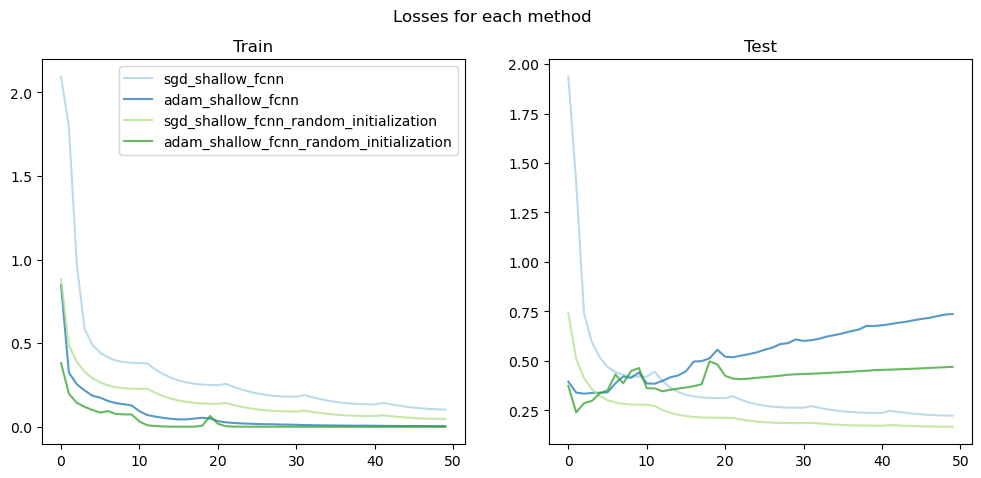

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

colormap = mpl.colormaps['Paired'].colors

for model_name, color in zip(to_val, colormap):
    try:
        models[model_name]
    except:
        print("WARNING: MISSING MODEL", model_name)
        continue
    
    e = models[model_name]

    axes[0].plot(e['train_loss'], label=model_name, color=color, alpha=0.75)
    axes[1].plot(e['test_loss'], label=model_name, color=color, alpha=0.75)


plt.suptitle("Losses for each method")
axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].legend()
plt.show()

In [73]:
# Calculate every score of each model and return it as a dataframe
DATA = {
    'name': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
    'Test Accuracy': []
}

for model_name in to_val:
    try:
        models[model_name]
    except:
        continue

    model = models[model_name]['model']
    
    DATA['name'].append(model_name)
    DATA['Train Accuracy'].append(macro_precision(val_model(model, train_loader, data)))
    DATA['Validation Accuracy'].append(macro_precision(val_model(model, val_loader, data)))
    DATA['Test Accuracy'].append(macro_precision(val_model(model, test_loader, data)))
df_performance = pd.DataFrame(DATA)
df_performance

EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 87.21it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 90.48it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:22<00:00, 453.89it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 84.12it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 94.02it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:21<00:00, 468.93it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 89.15it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 93.02it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:21<00:00, 467.73it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 84.76it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 88.25it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:21<00:00, 457.01it/s]


,name,Train Accuracy,Validation Accuracy,Test Accuracy
0,sgd_shallow_fcnn,0.975132,0.933801,0.859806
1,adam_shallow_fcnn,0.998956,0.925084,0.844416
2,sgd_shallow_fcnn_random_initialization,0.993588,0.951748,0.887012
3,adam_shallow_fcnn_random_initialization,1.000000,0.958032,0.898613


### CNN Hyperparameters: number of channels, which pooling to use

In [171]:
to_val = [
    'shallow_cnn_low',
    'shallow_cnn_med',
    'shallow_cnn_high',
]

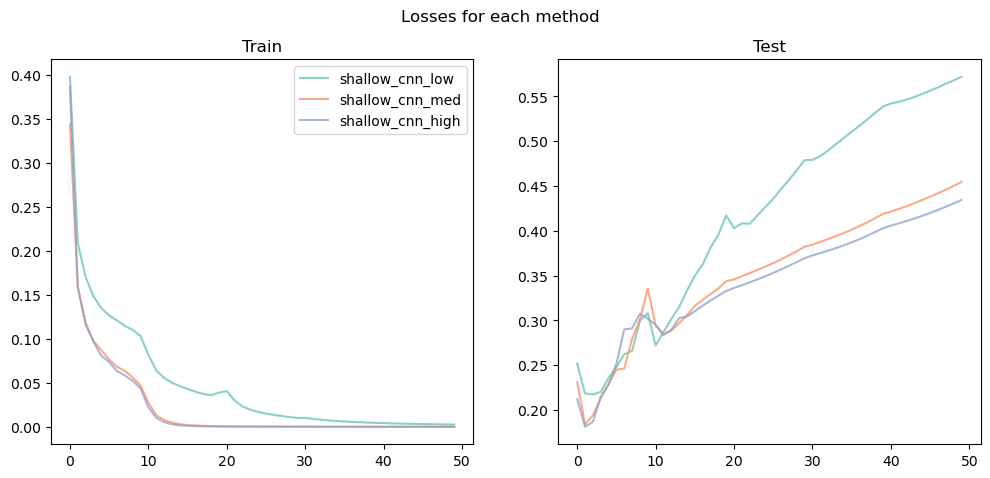

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

colormap = mpl.colormaps['Set2'].colors

for model_name, color in zip(to_val, colormap):
    try:
        models[model_name]
    except:
        print("WARNING: MISSING MODEL", model_name)
        continue
    
    e = models[model_name]

    axes[0].plot(e['train_loss'], label=model_name, color=color, alpha=0.75)
    axes[1].plot(e['test_loss'], label=model_name, color=color, alpha=0.75)


plt.suptitle("Losses for each method")
axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].legend()
plt.show()

In [77]:
# Calculate every score of each model and return it as a dataframe
DATA = {
    'name': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
    'Test Accuracy': []
}

for model_name in to_val:
    try:
        models[model_name]
    except:
        continue

    model = models[model_name]['model']
    
    DATA['name'].append(model_name)
    DATA['Train Accuracy'].append(macro_precision(val_model(model, train_loader, data)))
    DATA['Validation Accuracy'].append(macro_precision(val_model(model, val_loader, data)))
    DATA['Test Accuracy'].append(macro_precision(val_model(model, test_loader, data)))
df_performance = pd.DataFrame(DATA)
df_performance

EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 84.42it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 87.62it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:22<00:00, 435.81it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 85.30it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 83.64it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:22<00:00, 446.25it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 86.15it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 81.13it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:23<00:00, 429.37it/s]


,name,Train Accuracy,Validation Accuracy,Test Accuracy
0,shallow_cnn_low,0.999152,0.936001,0.866423
1,shallow_cnn_med,1.000000,0.957886,0.900096
2,shallow_cnn_high,1.000000,0.958268,0.907507


In [173]:
to_val = [
    'shallow_cnn_med',
    'shallow_cnn_minpool',
    'shallow_cnn_avgpool',
    'shallow_cnn_adaptive_avgpool',
]



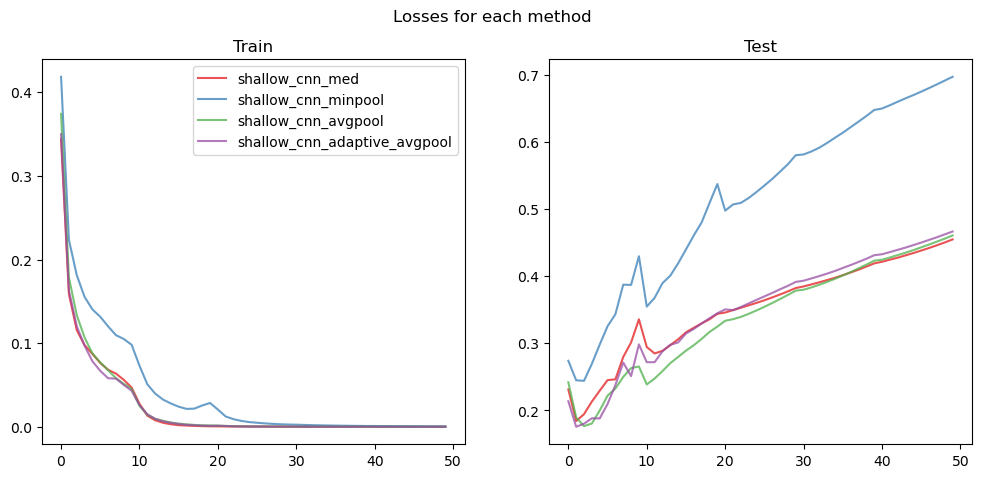

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

colormap = mpl.colormaps['Set1'].colors

for model_name, color in zip(to_val, colormap):
    try:
        models[model_name]
    except:
        print("WARNING: MISSING MODEL", model_name)
        continue
    
    e = models[model_name]

    axes[0].plot(e['train_loss'], label=model_name, color=color, alpha=0.75)
    axes[1].plot(e['test_loss'], label=model_name, color=color, alpha=0.75)


plt.suptitle("Losses for each method")
axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].legend()
plt.show()

In [80]:
# Calculate every score of each model and return it as a dataframe
DATA = {
    'name': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
    'Test Accuracy': []
}

for model_name in to_val:
    try:
        models[model_name]
    except:
        continue

    model = models[model_name]['model']
    
    DATA['name'].append(model_name)
    DATA['Train Accuracy'].append(macro_precision(val_model(model, train_loader, data)))
    DATA['Validation Accuracy'].append(macro_precision(val_model(model, val_loader, data)))
    DATA['Test Accuracy'].append(macro_precision(val_model(model, test_loader, data)))
df_performance = pd.DataFrame(DATA)
df_performance

EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 84.48it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 88.09it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:23<00:00, 419.18it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:05<00:00, 61.21it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:02<00:00, 62.42it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:26<00:00, 372.75it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 80.62it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 81.52it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:23<00:00, 429.13it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 85.81it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 84.39it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:24<00:00, 407.14it/s]


,name,Train Accuracy,Validation Accuracy,Test Accuracy
0,shallow_cnn_med,1.000000,0.957886,0.900096
1,shallow_cnn_minpool,0.999977,0.929172,0.855312
2,shallow_cnn_avgpool,1.000000,0.955191,0.902635
3,shallow_cnn_adaptive_avgpool,1.000000,0.957153,0.901174


In [81]:
%store models

Stored 'models' (dict)


Conlusions:
- Use Adam
- Use Maxpool
- Use a high initial amount of channels (32)

## Final Models: Deep CNN and Deep FCNN

In [86]:
name = 'deep_cnn'

models[name] = {}
entry = models[name] 

entry['model'] = DeepCNN()
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.01)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=5, gamma=0.75)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 25, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


329it [00:04, 73.80it/s]
141it [00:01, 92.23it/s]


Learning rate set to 0.01
Epoch: 1 | Train Loss: 0.3625 | Test Loss: 0.2492 | Train Accuracy: 89.0387 | Test Accuracy: 92.9163 | Time: 5.99


329it [00:04, 70.40it/s]
141it [00:01, 87.24it/s]


Epoch: 2 | Train Loss: 0.1581 | Test Loss: 0.1610 | Train Accuracy: 95.5173 | Test Accuracy: 95.9453 | Time: 6.30


329it [00:04, 70.34it/s]
141it [00:01, 92.54it/s]


Epoch: 3 | Train Loss: 0.1206 | Test Loss: 0.1437 | Train Accuracy: 96.6416 | Test Accuracy: 96.5100 | Time: 6.21


329it [00:04, 68.62it/s]
141it [00:01, 92.34it/s]


Epoch: 4 | Train Loss: 0.1009 | Test Loss: 0.1388 | Train Accuracy: 97.2323 | Test Accuracy: 96.6975 | Time: 6.33


329it [00:04, 71.12it/s]
141it [00:01, 97.51it/s]


Learning rate set to 0.0075
Epoch: 5 | Train Loss: 0.0866 | Test Loss: 0.1641 | Train Accuracy: 97.6181 | Test Accuracy: 96.3906 | Time: 6.08


329it [00:04, 68.25it/s]
141it [00:01, 89.58it/s]


Epoch: 6 | Train Loss: 0.0705 | Test Loss: 0.1624 | Train Accuracy: 98.1017 | Test Accuracy: 96.5190 | Time: 6.40


329it [00:04, 67.97it/s]
141it [00:01, 91.28it/s]


Epoch: 7 | Train Loss: 0.0594 | Test Loss: 0.1834 | Train Accuracy: 98.3589 | Test Accuracy: 96.0971 | Time: 6.39


329it [00:04, 70.69it/s]
141it [00:01, 93.75it/s]


Epoch: 8 | Train Loss: 0.0530 | Test Loss: 0.2090 | Train Accuracy: 98.6376 | Test Accuracy: 96.1417 | Time: 6.16


329it [00:04, 68.97it/s]
141it [00:01, 91.29it/s]


Epoch: 9 | Train Loss: 0.0494 | Test Loss: 0.2043 | Train Accuracy: 98.7495 | Test Accuracy: 96.2634 | Time: 6.32


329it [00:04, 76.08it/s]
141it [00:01, 97.66it/s]


Learning rate set to 0.005625
Epoch: 10 | Train Loss: 0.0465 | Test Loss: 0.2271 | Train Accuracy: 98.8067 | Test Accuracy: 95.8962 | Time: 5.77


329it [00:04, 70.25it/s]
141it [00:01, 89.91it/s]


Epoch: 11 | Train Loss: 0.0376 | Test Loss: 0.2306 | Train Accuracy: 99.0592 | Test Accuracy: 95.8962 | Time: 6.26


329it [00:04, 71.66it/s]
141it [00:01, 98.41it/s] 


Epoch: 12 | Train Loss: 0.0310 | Test Loss: 0.2251 | Train Accuracy: 99.2759 | Test Accuracy: 96.3482 | Time: 6.03


329it [00:04, 67.59it/s]
141it [00:01, 89.03it/s]


Epoch: 13 | Train Loss: 0.0260 | Test Loss: 0.2488 | Train Accuracy: 99.4117 | Test Accuracy: 96.1183 | Time: 6.46


329it [00:04, 68.79it/s]
141it [00:01, 90.19it/s]


Epoch: 14 | Train Loss: 0.0244 | Test Loss: 0.2127 | Train Accuracy: 99.4831 | Test Accuracy: 97.1641 | Time: 6.35


329it [00:05, 64.22it/s]
141it [00:01, 87.45it/s]


Learning rate set to 0.00421875
Epoch: 15 | Train Loss: 0.0218 | Test Loss: 0.2622 | Train Accuracy: 99.5522 | Test Accuracy: 96.3516 | Time: 6.75


329it [00:04, 71.30it/s]
141it [00:01, 81.29it/s]


Epoch: 16 | Train Loss: 0.0185 | Test Loss: 0.2300 | Train Accuracy: 99.6689 | Test Accuracy: 97.0536 | Time: 6.36


329it [00:04, 71.98it/s]
141it [00:01, 88.02it/s]


Epoch: 17 | Train Loss: 0.0153 | Test Loss: 0.2405 | Train Accuracy: 99.7761 | Test Accuracy: 97.0826 | Time: 6.18


329it [00:06, 52.48it/s]
141it [00:02, 51.85it/s]


Epoch: 18 | Train Loss: 0.0133 | Test Loss: 0.2355 | Train Accuracy: 99.8309 | Test Accuracy: 97.1663 | Time: 9.00


329it [00:04, 68.02it/s]
141it [00:01, 88.83it/s]


Epoch: 19 | Train Loss: 0.0103 | Test Loss: 0.2555 | Train Accuracy: 99.9190 | Test Accuracy: 97.1518 | Time: 6.43


329it [00:04, 69.48it/s]
141it [00:01, 85.54it/s]


Learning rate set to 0.0031640625
Epoch: 20 | Train Loss: 0.0095 | Test Loss: 0.2539 | Train Accuracy: 99.9643 | Test Accuracy: 97.1998 | Time: 6.39


329it [00:05, 62.42it/s]
141it [00:01, 78.55it/s]


Epoch: 21 | Train Loss: 0.0077 | Test Loss: 0.2717 | Train Accuracy: 100.0238 | Test Accuracy: 97.0491 | Time: 7.07


329it [00:04, 68.38it/s]
141it [00:01, 94.02it/s]


Epoch: 22 | Train Loss: 0.0050 | Test Loss: 0.2674 | Train Accuracy: 100.1358 | Test Accuracy: 97.1083 | Time: 6.32


329it [00:04, 71.88it/s]
141it [00:01, 91.34it/s]


Epoch: 23 | Train Loss: 0.0047 | Test Loss: 0.2737 | Train Accuracy: 100.1572 | Test Accuracy: 97.1429 | Time: 6.13


329it [00:04, 71.61it/s]
141it [00:01, 93.43it/s]


Epoch: 24 | Train Loss: 0.0039 | Test Loss: 0.2864 | Train Accuracy: 100.1786 | Test Accuracy: 97.1016 | Time: 6.11


329it [00:04, 71.72it/s]
141it [00:01, 92.34it/s]

Learning rate set to 0.002373046875
Epoch: 25 | Train Loss: 0.0038 | Test Loss: 0.2946 | Train Accuracy: 100.1810 | Test Accuracy: 97.0402 | Time: 6.12


In [89]:
name = 'deep_fcnn'

models[name] = {}
entry = models[name] 

entry['model'] = FCNN()
entry['optimizer'] = torch.optim.Adam(entry['model'].parameters(), lr = 0.005)
entry['scheduler'] = torch.optim.lr_scheduler.StepLR(entry['optimizer'], step_size=5, gamma=0.75)

(entry['train_loss'], entry['test_loss']) = train_model(entry['model'], 25, train_loader, val_loader, CE, entry['optimizer'], entry['scheduler'])

TRAINING MODEL!


0it [00:00, ?it/s]

329it [00:04, 68.19it/s]
141it [00:01, 91.52it/s]


Learning rate set to 0.005
Epoch: 1 | Train Loss: 0.5193 | Test Loss: 0.3697 | Train Accuracy: 84.8371 | Test Accuracy: 89.6183 | Time: 6.37


329it [00:04, 69.37it/s]
141it [00:01, 89.96it/s]


Epoch: 2 | Train Loss: 0.2919 | Test Loss: 0.3029 | Train Accuracy: 92.0422 | Test Accuracy: 92.3460 | Time: 6.32


329it [00:04, 67.75it/s]
141it [00:01, 92.45it/s]


Epoch: 3 | Train Loss: 0.2328 | Test Loss: 0.3093 | Train Accuracy: 93.6476 | Test Accuracy: 92.7969 | Time: 6.39


329it [00:05, 60.85it/s]
141it [00:02, 62.05it/s]


Epoch: 4 | Train Loss: 0.2042 | Test Loss: 0.3345 | Train Accuracy: 94.5646 | Test Accuracy: 92.6473 | Time: 7.69


329it [00:06, 53.72it/s]
141it [00:01, 71.00it/s]


Learning rate set to 0.00375
Epoch: 5 | Train Loss: 0.1759 | Test Loss: 0.3433 | Train Accuracy: 95.3601 | Test Accuracy: 92.6741 | Time: 8.12


329it [00:05, 61.80it/s]
141it [00:01, 81.50it/s]


Epoch: 6 | Train Loss: 0.1314 | Test Loss: 0.2917 | Train Accuracy: 96.6487 | Test Accuracy: 93.8984 | Time: 7.06


329it [00:05, 63.15it/s]
141it [00:01, 81.35it/s]


Epoch: 7 | Train Loss: 0.1058 | Test Loss: 0.3259 | Train Accuracy: 97.2275 | Test Accuracy: 93.7946 | Time: 6.95


329it [00:05, 59.83it/s]
141it [00:01, 81.67it/s]


Epoch: 8 | Train Loss: 0.1058 | Test Loss: 0.2982 | Train Accuracy: 97.3133 | Test Accuracy: 94.0179 | Time: 7.23


329it [00:05, 65.74it/s]
141it [00:01, 82.60it/s]


Epoch: 9 | Train Loss: 0.0967 | Test Loss: 0.3068 | Train Accuracy: 97.5395 | Test Accuracy: 94.3225 | Time: 6.72


329it [00:05, 64.02it/s]
141it [00:01, 86.58it/s]


Learning rate set to 0.0028125
Epoch: 10 | Train Loss: 0.0910 | Test Loss: 0.3292 | Train Accuracy: 97.6729 | Test Accuracy: 94.2355 | Time: 6.77


329it [00:05, 64.44it/s]
141it [00:01, 85.40it/s]


Epoch: 11 | Train Loss: 0.0708 | Test Loss: 0.2787 | Train Accuracy: 98.3160 | Test Accuracy: 95.0536 | Time: 6.76


329it [00:05, 64.51it/s]
141it [00:01, 86.04it/s]


Epoch: 12 | Train Loss: 0.0571 | Test Loss: 0.3267 | Train Accuracy: 98.6352 | Test Accuracy: 94.7042 | Time: 6.75


329it [00:05, 62.54it/s]
141it [00:01, 82.44it/s]


Epoch: 13 | Train Loss: 0.0541 | Test Loss: 0.3166 | Train Accuracy: 98.7638 | Test Accuracy: 95.0871 | Time: 6.98


329it [00:05, 65.38it/s]
141it [00:01, 86.14it/s]


Epoch: 14 | Train Loss: 0.0551 | Test Loss: 0.3161 | Train Accuracy: 98.6781 | Test Accuracy: 94.8359 | Time: 6.68


329it [00:05, 65.58it/s]
141it [00:01, 85.96it/s]


Learning rate set to 0.002109375
Epoch: 15 | Train Loss: 0.0511 | Test Loss: 0.3381 | Train Accuracy: 98.7710 | Test Accuracy: 94.8862 | Time: 6.66


329it [00:05, 65.03it/s]
141it [00:01, 84.24it/s]


Epoch: 16 | Train Loss: 0.0400 | Test Loss: 0.3187 | Train Accuracy: 99.0854 | Test Accuracy: 95.0480 | Time: 6.74


329it [00:05, 63.04it/s]
141it [00:01, 83.53it/s]


Epoch: 17 | Train Loss: 0.0361 | Test Loss: 0.3185 | Train Accuracy: 99.2569 | Test Accuracy: 95.3940 | Time: 6.91


329it [00:05, 62.12it/s]
141it [00:01, 79.28it/s]


Epoch: 18 | Train Loss: 0.0322 | Test Loss: 0.3460 | Train Accuracy: 99.3926 | Test Accuracy: 95.1819 | Time: 7.08


329it [00:05, 61.02it/s]
141it [00:01, 83.95it/s]


Epoch: 19 | Train Loss: 0.0329 | Test Loss: 0.3918 | Train Accuracy: 99.3045 | Test Accuracy: 94.7578 | Time: 7.08


329it [00:05, 60.80it/s]
141it [00:01, 85.77it/s]


Learning rate set to 0.00158203125
Epoch: 20 | Train Loss: 0.0374 | Test Loss: 0.3326 | Train Accuracy: 99.1830 | Test Accuracy: 95.4107 | Time: 7.06


329it [00:04, 66.33it/s]
141it [00:01, 88.89it/s]


Epoch: 21 | Train Loss: 0.0255 | Test Loss: 0.3103 | Train Accuracy: 99.5117 | Test Accuracy: 95.6205 | Time: 6.55


329it [00:05, 58.03it/s]
141it [00:01, 99.77it/s] 


Epoch: 22 | Train Loss: 0.0183 | Test Loss: 0.3377 | Train Accuracy: 99.7308 | Test Accuracy: 95.5257 | Time: 7.09


329it [00:04, 66.69it/s]
141it [00:01, 85.18it/s]


Epoch: 23 | Train Loss: 0.0160 | Test Loss: 0.3681 | Train Accuracy: 99.7737 | Test Accuracy: 95.3549 | Time: 6.60


329it [00:04, 67.69it/s]
141it [00:01, 93.30it/s]


Epoch: 24 | Train Loss: 0.0193 | Test Loss: 0.3648 | Train Accuracy: 99.7094 | Test Accuracy: 95.3493 | Time: 6.38


329it [00:04, 69.03it/s]
141it [00:01, 94.57it/s]


Learning rate set to 0.0011865234375
Epoch: 25 | Train Loss: 0.0208 | Test Loss: 0.3706 | Train Accuracy: 99.6546 | Test Accuracy: 95.3783 | Time: 6.27


In [90]:
%store models

Stored 'models' (dict)


## Saving Models

In [91]:
# save models and their losses
for model_name in list(models.keys()):
    e = models[model_name]
    save_model(
        e['model'],
        e['train_loss'],
        e['test_loss'],
        model_name
    )

In [ ]:
%store models

In [ ]:
%store -r models 
# run to load models

# Model Evaluation

## General Analysis

In [92]:
# define auxiliary functions to get common metrics from a confusion matrix (accuracy, recall, F1-score, ...)

def macro_f1_score(CM, get_avg = True):
    precision = macro_precision(CM, get_avg=False)
    recall = macro_recall(CM, get_avg=False)
    
    f1_scores =  2 * np.divide(np.multiply(precision, recall), (precision+recall))
    return f1_scores.mean() if get_avg else f1_scores

def macro_recall(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        rowsum = CM[i, :].sum()

        scores[i] = true_predicted/rowsum if rowsum != 0 else 0

    return scores.mean() if get_avg else scores

def macro_precision(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        colsum = CM[:, i].sum()

        scores[i] = true_predicted/colsum if colsum != 0 else 0

    return scores.mean() if get_avg else scores
    
def macro_error(CM, get_avg = True):
    return 1-macro_precision(CM, get_avg)


In [93]:
import seaborn as sns 
def plot_confusion_matrix(CM, ax, name="No Name"):
    sns.heatmap(CM, annot=True, cbar=False, ax=ax, fmt='g')
    ax.set_title(f"Confusion Matrix of {name}")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Actual Class")

In [94]:
def model_results(model, train_loader, val_loader, test_loader, data, name):
    CM_train = val_model(model, train_loader, data)
    CM_val = val_model(model, val_loader, data)
    CM_test = val_model(model, test_loader, data)
    CMs = {'TRAIN': CM_train, 'VALIDATION': CM_val, 'TESTING': CM_test}

    for CM_name in CMs:
        CM = CMs[CM_name]
        print(f"TESTING MODEL ON {CM_name} DATA")
        print(f"MODEL F1-SCORE: {macro_f1_score(CM)}\nMODEL PRECISION: {macro_precision(CM)}\nMODEL RECALL: {macro_recall(CM)}")
        print()

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    for i, CM_name in enumerate(CMs):
        CM = CMs[CM_name]
        plot_confusion_matrix(CM, ax[i], name+f" ({CM_name})")

    plt.show()


In [97]:
import pprint
pprint.pprint(models.keys())

dict_keys(['sgd_shallow_fcnn', 'adam_shallow_fcnn', 'sgd_shallow_fcnn_random_initialization', 'adam_shallow_fcnn_random_initialization', 'shallow_cnn_low', 'shallow_cnn_med', 'shallow_cnn_high', 'shallow_cnn_minpool', 'shallow_cnn_avgpool', 'shallow_cnn_adaptive_avgpool', 'deep_cnn', 'deep_fcnn'])


In [160]:
# a posteriori list of models to plot
to_plot = [
    'shallow_cnn_med',
    'deep_cnn',
    'adam_shallow_fcnn_random_initialization',
    'deep_fcnn'
]

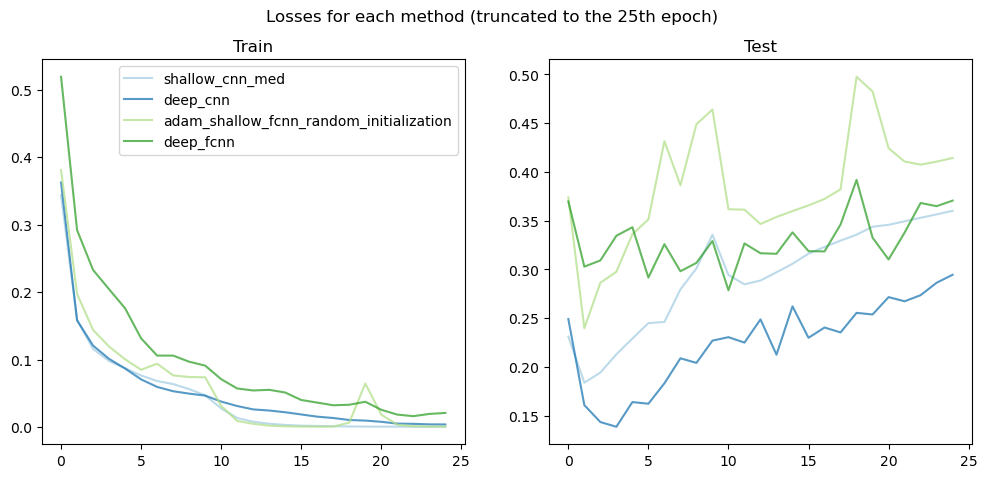

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

colormap = mpl.colormaps['Paired'].colors

for model_name, color in zip(to_plot, colormap):
    try:
        models[model_name]
    except:
        print("WARNING: MISSING MODEL", model_name)
        continue
    
    e = models[model_name]

    axes[0].plot(e['train_loss'][:25], label=model_name, color=color, alpha=0.75)
    axes[1].plot(e['test_loss'][:25], label=model_name, color=color, alpha=0.75)


plt.suptitle("Losses for each method (truncated to the 25th epoch)")
axes[0].set_title("Train")
axes[1].set_title("Test")

axes[0].legend()
plt.show()

In [101]:
import pandas as pd

In [102]:
# Calculate every score of each model and return it as a dataframe
DATA = {
    'name': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
    'Test Accuracy': []
}

for model_name in to_plot:
    try:
        models[model_name]
    except:
        continue

    model = models[model_name]['model']
    
    DATA['name'].append(model_name)
    DATA['Train Accuracy'].append(macro_precision(val_model(model, train_loader, data)))
    DATA['Validation Accuracy'].append(macro_precision(val_model(model, val_loader, data)))
    DATA['Test Accuracy'].append(macro_precision(val_model(model, test_loader, data)))


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 83.79it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 88.27it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:23<00:00, 419.15it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:04<00:00, 82.11it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 82.03it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:26<00:00, 375.59it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 88.05it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 87.58it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:21<00:00, 464.24it/s]


EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 84.12it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 83.21it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:26<00:00, 373.21it/s]


In [103]:
df_performance = pd.DataFrame(DATA)


In [104]:
df_performance

,name,Train Accuracy,Validation Accuracy,Test Accuracy
0,shallow_cnn_med,1.000000,0.957886,0.900096
1,deep_cnn,0.996232,0.963932,0.908054
2,adam_shallow_fcnn_random_initialization,1.000000,0.958032,0.898613
3,deep_fcnn,0.994109,0.947209,0.874761


## Specific Analysis

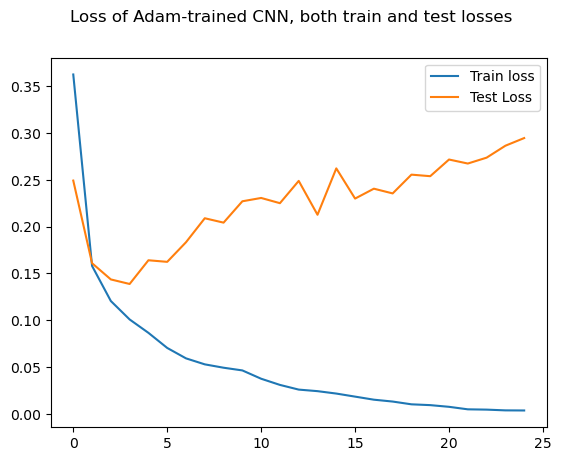

In [105]:
# plot test and train loss

fig, ax = plt.subplots() 

ax.plot(models['deep_cnn']['train_loss'], label="Train loss")
ax.plot(models['deep_cnn']['test_loss'], label= "Test Loss")

plt.suptitle("Loss of Adam-trained CNN, both train and test losses")

plt.legend()
plt.show()

EVALUATING MODEL


100%|██████████| 329/329 [00:03<00:00, 82.72it/s]


EVALUATING MODEL


100%|██████████| 141/141 [00:01<00:00, 83.54it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:27<00:00, 357.64it/s]


TESTING MODEL ON TRAIN DATA
MODEL F1-SCORE: 0.9962184075649484
MODEL PRECISION: 0.9962322958384116
MODEL RECALL: 0.996233012026245

TESTING MODEL ON VALIDATION DATA
MODEL F1-SCORE: 0.9635421159597313
MODEL PRECISION: 0.9639320980786141
MODEL RECALL: 0.9634435050836144

TESTING MODEL ON TESTING DATA
MODEL F1-SCORE: 0.9069109715408441
MODEL PRECISION: 0.9080535042278342
MODEL RECALL: 0.907



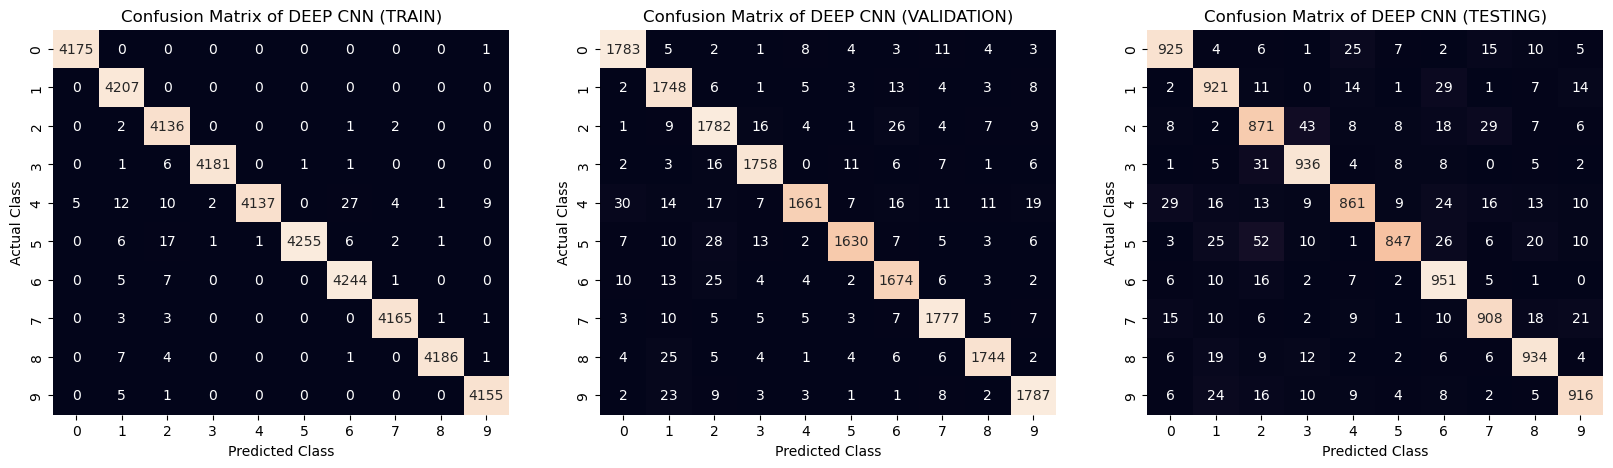

In [106]:
model_results(models['deep_cnn']['model'], train_loader, val_loader, test_loader, data, "DEEP CNN")

In [123]:
precisions = macro_precision(val_model(models['deep_cnn']['model'], test_loader, data), get_avg=False)
recalls = macro_recall(val_model(models['deep_cnn']['model'], test_loader, data), get_avg=False)
f1_scores = macro_f1_score(val_model(models['deep_cnn']['model'], test_loader, data), get_avg=False)
cats = data.targets.unique()

EVALUATING MODEL


100%|██████████| 10000/10000 [00:25<00:00, 398.33it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:22<00:00, 445.77it/s]


EVALUATING MODEL


100%|██████████| 10000/10000 [00:24<00:00, 416.08it/s]


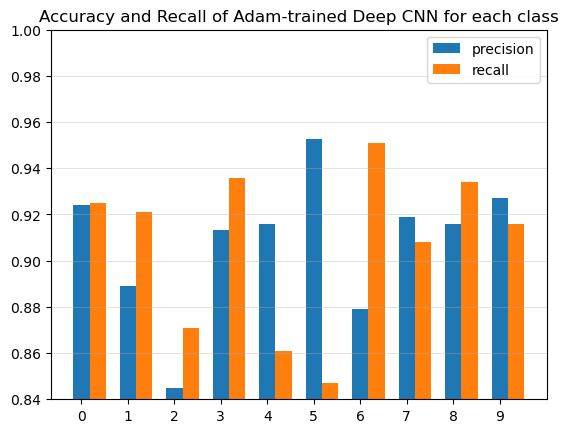

In [130]:
fig, ax = plt.subplots()

w = 0.35
ax.bar(cats, precisions, width=w, label='precision')
ax.bar(cats+w, recalls, width=w, label='recall')

ax.legend()

plt.grid(True, 'major', 'y', ls='-', lw=.5, alpha=.5)

ax.set_ylim(0.84, 1)
ax.set_xticks(cats)
ax.set_title("Accuracy and Recall of Adam-trained Deep CNN for each class")

plt.show()

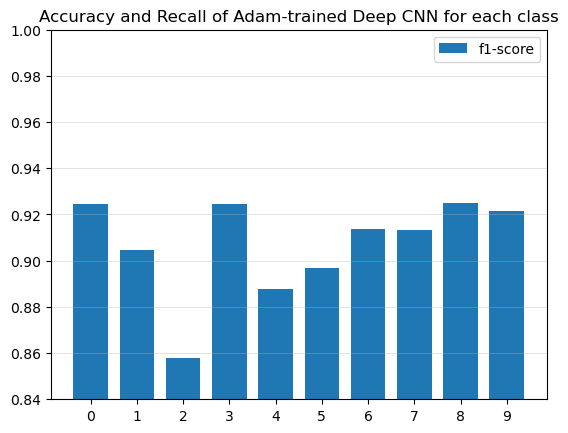

In [129]:
fig, ax = plt.subplots()

w = 0.75
ax.bar(cats, f1_scores, width=w, label='f1-score')

ax.legend()

plt.grid(True, 'major', 'y', ls='-', lw=.5, alpha=.5)

ax.set_ylim(0.84, 1)
ax.set_xticks(cats)
ax.set_title("Accuracy and Recall of Adam-trained Deep CNN for each class")

plt.show()

In [175]:
%store models

Stored 'models' (dict)
